1: Imports and Environment Setup
=====================================
This cell imports all necessary libraries and sets up the computing environment.

Key Dependencies:
- PyTorch: Deep learning framework
- PyTorch Geometric: For Graph Neural Networks
- NumPy/Pandas: Data manipulation
- SciPy: For Hungarian algorithm (optimal assignment)
- OpenCV: Image processing (optional, for visual features)

In [1]:
import os
import json
import glob
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass, field
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Optional: PyTorch Geometric for GNN
try:
    import torch_geometric
    from torch_geometric.nn import GCNConv, GATConv, TransformerConv, global_mean_pool
    from torch_geometric.data import Data, Batch
    HAS_TORCH_GEOMETRIC = True
except ImportError:
    HAS_TORCH_GEOMETRIC = False
    print("⚠️ PyTorch Geometric not installed. Using simplified GNN implementation.")
    print("   Install with: pip install torch-geometric")

# Optional: For visual features
try:
    import cv2
    HAS_OPENCV = True
except ImportError:
    HAS_OPENCV = False
    print("⚠️ OpenCV not installed. Visual features disabled.")

# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

warnings.filterwarnings('ignore', category=UserWarning)

🖥️ Using device: cuda
   GPU: NVIDIA GeForce GTX 1650 Ti


2: Configuration and Constants
====================================
Central configuration for the entire pipeline. Modify these values to tune 
the model behavior, data paths, and training hyperparameters.

Key Configuration Sections:
1. Path Configuration: Dataset locations
2. Skeleton Configuration: Joint definitions and connections
3. Model Configuration: Architecture hyperparameters
4. Training Configuration: Learning rate, batch size, etc.
5. Matching Configuration: Thresholds and constraints

In [20]:
@dataclass
class Config:
    """Central configuration class for the skeleton matching pipeline."""
    
    # ===================
    # Path Configuration
    # ===================
    base_path: str = "."
    ground_truth_dir: str = "Ground_Truth"
    mmpose_output_dir: str = "MMPose_Output"
    output_dir: str = "Matching_Output"
    
    # ===================
    # Skeleton Configuration
    # ===================
    joint_names: List[str] = field(default_factory=lambda: [
        "RightArm", "LeftArm", "RightForeArm", "LeftForeArm",
        "RightHand", "LeftHand", "RightUpLeg", "LeftUpLeg",
        "RightLeg", "LeftLeg", "RightFoot", "LeftFoot"
    ])
    
    skeleton_edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (0, 2), (2, 4),   # Right arm
        (1, 3), (3, 5),   # Left arm
        (6, 8), (8, 10),  # Right leg
        (7, 9), (9, 11),  # Left leg
        (0, 1),           # Shoulders
        (6, 7),           # Hips
        (0, 6), (1, 7),   # Torso
    ])
    
    num_joints: int = 12
    
    # ===================
    # Image Configuration
    # ===================
    image_width: int = 1920
    image_height: int = 1080
    
    # ===================
    # Model Configuration (ADJUSTED - smaller model)
    # ===================
    joint_feat_dim: int = 32       # Reduced from 64
    skeleton_feat_dim: int = 64    # Reduced from 128
    hidden_dim: int = 128          # Reduced from 256
    
    num_gnn_layers: int = 2        # Reduced from 3
    gnn_heads: int = 4
    dropout: float = 0.2           # Increased from 0.1
    
    num_cross_attn_layers: int = 1  # Reduced from 2
    
    # ===================
    # Training Configuration (ADJUSTED)
    # ===================
    batch_size: int = 8            # Reduced from 16
    learning_rate: float = 5e-3    # Reduced from 1e-3
    weight_decay: float = 1e-3     # Increased from 1e-4
    num_epochs: int = 100          # Reduced from 300
    patience: int = 20             # Increased from 15
    
    # Loss weights
    matching_loss_weight: float = 1.0
    geometric_loss_weight: float = 0.5
    contrastive_loss_weight: float = 0.1  # Reduced from 0.3
    
    # ===================
    # Matching Configuration
    # ===================
    max_y_disparity: float = 0.1
    max_depth_ratio: float = 2.0
    
    min_joint_confidence: float = 0.3
    min_skeleton_confidence: float = 0.5
    min_visible_joints: int = 6
    
    match_threshold: float = 0.5
    unmatched_cost: float = 1.0
    
    # ===================
    # Temporal Configuration
    # ===================
    use_temporal: bool = True
    temporal_window: int = 5
    temporal_weight: float = 0.3
    
    # ===================
    # Data Augmentation (ADJUSTED - more augmentation)
    # ===================
    augment_train: bool = True
    aug_noise_std: float = 0.03    # Increased from 0.02
    aug_dropout_prob: float = 0.15  # Increased from 0.1
    aug_scale_range: Tuple[float, float] = (0.85, 1.15)
    
    # Matching thresholds
    confidence_threshold: float = 0.3
    max_disparity: float = 100.0
    temporal_window: int = 5
    
    def __post_init__(self):
        os.makedirs(self.output_dir, exist_ok=True)

# Create global config instance
config = Config()

print("📋 Configuration Summary:")
print(f"   Model size: {config.joint_feat_dim}->{config.skeleton_feat_dim}->{config.hidden_dim}")
print(f"   GNN Layers: {config.num_gnn_layers}")
print(f"   Batch Size: {config.batch_size}")
print(f"   Learning Rate: {config.learning_rate}")
print(f"   Weight Decay: {config.weight_decay}")
print(f"   Dropout: {config.dropout}")

📋 Configuration Summary:
   Model size: 32->64->128
   GNN Layers: 2
   Batch Size: 8
   Learning Rate: 0.005
   Weight Decay: 0.001
   Dropout: 0.2


3: Data Loading Utilities
===============================
Functions to load and parse the dataset structure including:
- Ground truth skeletal positions (World, CamLeft, CamRight CSVs)
- MMPose detection outputs (JSON format)
- Camera intrinsics and extrinsics

Key Functions:
- load_camera_params(): Parse camera intrinsic/extrinsic parameters
- load_ground_truth_scene(): Load GT skeletal data for a scene
- load_mmpose_detections(): Load MMPose JSON outputs
- create_frame_pairs(): Create paired data for training

In [3]:
def parse_camera_intrinsics(filepath: str) -> Dict:
    """
    Parse camera intrinsics file.
    
    Args:
        filepath: Path to camera_intrinsics.txt
        
    Returns:
        Dictionary with camera parameters for left and right cameras
    """
    params = {
        'left': {},
        'right': {},
        'baseline': None
    }
    
    current_camera = None
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        # Skip comments and empty lines
        if line.startswith('#') or not line:
            i += 1
            continue
        
        # Parse key-value pairs
        if line.startswith('LEFT_'):
            current_camera = 'left'
            key = line.replace('LEFT_', '').split(':')[0].lower()
        elif line.startswith('RIGHT_'):
            current_camera = 'right'
            key = line.replace('RIGHT_', '').split(':')[0].lower()
        elif line.startswith('BASELINE'):
            params['baseline'] = float(line.split(':')[1].strip())
            i += 1
            continue
        else:
            i += 1
            continue
        
        # Get value after colon
        if ':' in line:
            value_str = line.split(':', 1)[1].strip()
            
            # Check if this is a matrix (next lines contain data)
            if 'matrix' in key.lower() and not value_str:
                matrix_lines = []
                i += 1
                while i < len(lines) and lines[i].strip() and not lines[i].strip().startswith(('#', 'LEFT', 'RIGHT', 'BASELINE')):
                    matrix_lines.append([float(x) for x in lines[i].strip().split()])
                    i += 1
                params[current_camera][key] = np.array(matrix_lines)
                continue
            elif value_str:
                # Parse single line value
                values = [float(x) for x in value_str.split()]
                if len(values) == 1:
                    params[current_camera][key] = values[0]
                else:
                    params[current_camera][key] = np.array(values)
        
        i += 1
    
    return params


def load_ground_truth_skeleton(csv_path: str) -> pd.DataFrame:
    """
    Load skeleton data from a CSV file.
    
    Args:
        csv_path: Path to CamLeft.csv, CamRight.csv, or World.csv
        
    Returns:
        DataFrame with columns for each joint coordinate
    """
    return pd.read_csv(csv_path)


def skeleton_df_to_array(df: pd.DataFrame, joint_names: List[str]) -> np.ndarray:
    """
    Convert skeleton DataFrame to numpy array.
    
    Args:
        df: DataFrame from load_ground_truth_skeleton
        joint_names: List of joint names
        
    Returns:
        Array of shape (num_frames, num_joints, 3) for 3D
        or (num_frames, num_joints, 2/3) for 2D projections
    """
    num_frames = len(df)
    num_joints = len(joint_names)
    
    # Determine if 2D or 3D based on columns
    sample_cols = [c for c in df.columns if joint_names[0] in c]
    num_coords = len(sample_cols)
    
    skeleton_array = np.zeros((num_frames, num_joints, num_coords))
    
    for j, joint in enumerate(joint_names):
        if num_coords == 3:
            skeleton_array[:, j, 0] = df[f'{joint}_X'].values
            skeleton_array[:, j, 1] = df[f'{joint}_Y'].values
            skeleton_array[:, j, 2] = df[f'{joint}_Z'].values
        else:
            skeleton_array[:, j, 0] = df[f'{joint}_X'].values
            skeleton_array[:, j, 1] = df[f'{joint}_Y'].values
    
    return skeleton_array


def load_mmpose_json(json_path: str) -> List[Dict]:
    """
    Load MMPose detection JSON file.
    
    Args:
        json_path: Path to scene JSON file
        
    Returns:
        List of frame dictionaries
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data


def parse_mmpose_frame(frame_data: Dict, joint_names: List[str]) -> Dict:
    """
    Parse a single frame from MMPose output.
    
    Args:
        frame_data: Dictionary for one frame from MMPose JSON
        joint_names: List of joint names
        
    Returns:
        Dictionary with parsed skeleton data:
        - 'skeletons': List of (num_joints, 2) arrays
        - 'confidences': List of (num_joints,) arrays
        - 'bboxes': List of [x1, y1, x2, y2] arrays
        - 'bbox_scores': List of float scores
    """
    parsed = {
        'frame_index': frame_data['frame_index'],
        'skeletons': [],
        'confidences': [],
        'bboxes': [],
        'bbox_scores': []
    }
    
    num_persons = len(frame_data['keypoints'])
    
    for p in range(num_persons):
        # Get keypoints
        keypoints = np.array(frame_data['keypoints'][p])  # (num_joints, 2)
        confidences = np.array(frame_data['keypoint_confidences'][p])  # (num_joints,)
        
        parsed['skeletons'].append(keypoints)
        parsed['confidences'].append(confidences)
        
        if frame_data['bboxes']:
            parsed['bboxes'].append(np.array(frame_data['bboxes'][p]))
            parsed['bbox_scores'].append(frame_data['bbox_scores'][p])
    
    return parsed


def load_scene_data(scene_path: str, config: Config) -> Dict:
    """
    Load all data for a single scene.
    
    Args:
        scene_path: Path to scene directory in Ground_Truth
        config: Configuration object
        
    Returns:
        Dictionary containing:
        - 'camera_params': Camera intrinsics/extrinsics
        - 'characters': Dict mapping character name to their GT data
        - 'num_frames': Total number of frames
    """
    scene_data = {
        'scene_path': scene_path,
        'scene_name': os.path.basename(scene_path),
        'characters': {},
        'num_frames': 0
    }
    
    # Load camera parameters
    intrinsics_path = os.path.join(scene_path, 'camera_intrinsics.txt')
    if os.path.exists(intrinsics_path):
        scene_data['camera_params'] = parse_camera_intrinsics(intrinsics_path)
    
    # Load character data
    characters_dir = os.path.join(scene_path, 'Characters')
    if os.path.exists(characters_dir):
        for char_name in os.listdir(characters_dir):
            char_path = os.path.join(characters_dir, char_name)
            if os.path.isdir(char_path):
                char_data = {}
                
                # Load each CSV
                for csv_name in ['CamLeft.csv', 'CamRight.csv', 'World.csv']:
                    csv_path = os.path.join(char_path, csv_name)
                    if os.path.exists(csv_path):
                        df = load_ground_truth_skeleton(csv_path)
                        key = csv_name.replace('.csv', '').lower()
                        char_data[key] = skeleton_df_to_array(df, config.joint_names)
                        scene_data['num_frames'] = max(scene_data['num_frames'], len(df))
                
                scene_data['characters'][char_name] = char_data
    
    return scene_data


def load_mmpose_scene(scene_path: str, config: Config) -> Dict:
    """
    Load MMPose detections for a scene.
    
    Args:
        scene_path: Path to scene directory in MMPose_Output
        config: Configuration object
        
    Returns:
        Dictionary with 'left' and 'right' parsed frame data
    """
    mmpose_data = {'left': [], 'right': []}
    
    for camera in ['Left', 'Right']:
        camera_dir = os.path.join(scene_path, camera)
        # Find JSON file
        json_files = glob.glob(os.path.join(camera_dir, '*.json'))
        if json_files:
            frames = load_mmpose_json(json_files[0])
            for frame in frames:
                parsed = parse_mmpose_frame(frame, config.joint_names)
                mmpose_data[camera.lower()].append(parsed)
    
    return mmpose_data


def get_scene_list(base_path: str, gt_dir: str) -> List[str]:
    """Get list of all scene directories."""
    gt_path = os.path.join(base_path, gt_dir)
    scenes = []
    for item in os.listdir(gt_path):
        scene_path = os.path.join(gt_path, item)
        if os.path.isdir(scene_path) and 'Scene' in item:
            scenes.append(item)
    return sorted(scenes)


# Test loading
print("📂 Available Scenes:")
try:
    scenes = get_scene_list(config.base_path, config.ground_truth_dir)
    for scene in scenes:
        print(f"   - {scene}")
except FileNotFoundError:
    print("   ⚠️ Dataset not found. Please set config.base_path correctly.")

📂 Available Scenes:
   - Scene 0 - One Person (104 frames)
   - Scene 1 - Crossing (276 frames)
   - Scene 2 - Pedestrian Bridge (103 frames)
   - Scene 3 - Busy Streets (93 frames)
   - Scene 4 - Side way (128 frames)
   - Scene 4a - dawn (129 frames)
   - Scene 4b - Night (140 frames)


4: Feature Extraction
===========================
Extract meaningful features from skeleton data for matching.

Feature Types:
1. Geometric Features:
   - Normalized joint positions
   - Bone lengths (scale-invariant)
   - Joint angles
   - Skeleton bounding box properties

2. Structural Features:
   - Pose signature (histogram of joint positions)
   - Symmetry measures
   
3. Confidence-Weighted Features:
   - Weighted aggregation based on detection confidence

These features are designed to be:
- View-invariant where possible
- Robust to partial occlusion
- Discriminative between different people

In [4]:
class SkeletonFeatureExtractor:
    """
    Extract features from 2D skeleton detections.
    
    This class computes various geometric and structural features
    that are useful for cross-view skeleton matching.
    """
    
    def __init__(self, config: Config):
        self.config = config
        self.joint_names = config.joint_names
        self.edges = config.skeleton_edges
        
    def normalize_skeleton(self, skeleton: np.ndarray, 
                          image_size: Tuple[int, int] = None) -> np.ndarray:
        """
        Normalize skeleton coordinates to [0, 1] range.
        
        Args:
            skeleton: (num_joints, 2) array of joint positions
            image_size: (width, height) for normalization, uses config if None
            
        Returns:
            Normalized skeleton array
        """
        if image_size is None:
            image_size = (self.config.image_width, self.config.image_height)
        
        normalized = skeleton.copy().astype(np.float32)
        
        # Handle missing joints (marked as [-1, -1])
        valid_mask = ~np.all(skeleton == -1, axis=1)
        
        normalized[valid_mask, 0] /= image_size[0]
        normalized[valid_mask, 1] /= image_size[1]
        normalized[~valid_mask] = 0  # Set invalid to 0 (will be masked later)
        
        return normalized
    
    def compute_bone_lengths(self, skeleton: np.ndarray, 
                            confidences: np.ndarray = None) -> np.ndarray:
        """
        Compute bone lengths for all edges.
        
        Args:
            skeleton: (num_joints, 2) normalized skeleton
            confidences: (num_joints,) confidence scores
            
        Returns:
            Array of bone lengths for each edge
        """
        bone_lengths = []
        
        for i, j in self.edges:
            # Check if both joints are valid
            if np.all(skeleton[i] != 0) and np.all(skeleton[j] != 0):
                length = np.linalg.norm(skeleton[i] - skeleton[j])
                
                # Weight by confidence if available
                if confidences is not None:
                    weight = min(confidences[i], confidences[j])
                    bone_lengths.append(length * weight)
                else:
                    bone_lengths.append(length)
            else:
                bone_lengths.append(0)
        
        return np.array(bone_lengths)
    
    def compute_joint_angles(self, skeleton: np.ndarray) -> np.ndarray:
        """
        Compute angles at each joint (where applicable).
        
        Returns angles for joints that are part of a kinematic chain.
        """
        angles = []
        
        # Define triplets for angle computation (joint, parent, child)
        angle_triplets = [
            (2, 0, 4),   # Right elbow: shoulder-elbow-hand
            (3, 1, 5),   # Left elbow: shoulder-elbow-hand
            (8, 6, 10),  # Right knee: hip-knee-foot
            (9, 7, 11),  # Left knee: hip-knee-foot
        ]
        
        for joint, parent, child in angle_triplets:
            if (np.all(skeleton[joint] != 0) and 
                np.all(skeleton[parent] != 0) and 
                np.all(skeleton[child] != 0)):
                
                v1 = skeleton[parent] - skeleton[joint]
                v2 = skeleton[child] - skeleton[joint]
                
                # Compute angle using dot product
                cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
                angle = np.arccos(np.clip(cos_angle, -1, 1))
                angles.append(angle / np.pi)  # Normalize to [0, 1]
            else:
                angles.append(0.5)  # Default to neutral angle
        
        return np.array(angles)
    
    def compute_bbox_features(self, skeleton: np.ndarray, 
                             confidences: np.ndarray = None) -> np.ndarray:
        """
        Compute bounding box features from skeleton.
        
        Returns:
            [center_x, center_y, width, height, aspect_ratio]
        """
        valid_mask = ~np.all(skeleton == 0, axis=1)
        
        if not np.any(valid_mask):
            return np.zeros(5)
        
        valid_joints = skeleton[valid_mask]
        
        if confidences is not None:
            valid_conf = confidences[valid_mask]
            # Weighted centroid
            weights = valid_conf / (valid_conf.sum() + 1e-8)
            center = np.average(valid_joints, axis=0, weights=weights)
        else:
            center = valid_joints.mean(axis=0)
        
        min_coords = valid_joints.min(axis=0)
        max_coords = valid_joints.max(axis=0)
        
        width = max_coords[0] - min_coords[0]
        height = max_coords[1] - min_coords[1]
        aspect_ratio = width / (height + 1e-8)
        
        return np.array([center[0], center[1], width, height, aspect_ratio])
    
    def compute_symmetry_features(self, skeleton: np.ndarray) -> np.ndarray:
        """
        Compute symmetry-based features.
        
        Measures how symmetric the pose is (left vs right side).
        """
        # Pairs of symmetric joints
        symmetric_pairs = [
            (0, 1),   # Right/Left Arm (shoulder)
            (2, 3),   # Right/Left ForeArm (elbow)
            (4, 5),   # Right/Left Hand
            (6, 7),   # Right/Left UpLeg (hip)
            (8, 9),   # Right/Left Leg (knee)
            (10, 11), # Right/Left Foot
        ]
        
        symmetry_scores = []
        
        for right_idx, left_idx in symmetric_pairs:
            if (np.all(skeleton[right_idx] != 0) and 
                np.all(skeleton[left_idx] != 0)):
                # Compute relative position difference
                diff = np.abs(skeleton[right_idx] - skeleton[left_idx])
                symmetry_scores.append(diff[0])  # X difference
                symmetry_scores.append(diff[1])  # Y difference
            else:
                symmetry_scores.extend([0, 0])
        
        return np.array(symmetry_scores)
    
    def compute_visibility_mask(self, skeleton: np.ndarray, 
                               confidences: np.ndarray,
                               threshold: float = None) -> np.ndarray:
        """
        Create a binary visibility mask for joints.
        """
        if threshold is None:
            threshold = self.config.min_joint_confidence
        
        # Joint is visible if not [-1, -1] and confidence above threshold
        position_valid = ~np.all(skeleton == -1, axis=1)
        confidence_valid = confidences >= threshold
        
        return position_valid & confidence_valid
    
    def extract_features(self, skeleton: np.ndarray, 
                        confidences: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Extract all features from a skeleton.
        
        Args:
            skeleton: (num_joints, 2) raw skeleton coordinates
            confidences: (num_joints,) confidence scores
            
        Returns:
            Dictionary of feature arrays
        """
        # Normalize skeleton
        norm_skeleton = self.normalize_skeleton(skeleton)
        visibility = self.compute_visibility_mask(skeleton, confidences)
        
        features = {
            'normalized_joints': norm_skeleton,  # (num_joints, 2)
            'visibility_mask': visibility,       # (num_joints,)
            'confidences': confidences,          # (num_joints,)
            'bone_lengths': self.compute_bone_lengths(norm_skeleton, confidences),
            'joint_angles': self.compute_joint_angles(norm_skeleton),
            'bbox_features': self.compute_bbox_features(norm_skeleton, confidences),
            'symmetry_features': self.compute_symmetry_features(norm_skeleton),
        }
        
        # Compute aggregate confidence
        if visibility.sum() > 0:
            features['mean_confidence'] = confidences[visibility].mean()
        else:
            features['mean_confidence'] = 0.0
        
        features['num_visible_joints'] = visibility.sum()
        
        return features


class GeometricMatcher:
    """
    Compute geometric constraints for stereo skeleton matching.
    
    Uses epipolar geometry and known camera parameters to validate matches.
    """
    
    def __init__(self, config: Config, camera_params: Dict = None):
        self.config = config
        self.camera_params = camera_params
        self.baseline = camera_params.get('baseline', 1.0) if camera_params else 1.0
    
    def compute_epipolar_error(self, left_skeleton: np.ndarray, 
                               right_skeleton: np.ndarray,
                               left_conf: np.ndarray,
                               right_conf: np.ndarray) -> float:
        """
        Compute epipolar constraint error.
        
        For a horizontal stereo setup, corresponding points should have
        similar Y coordinates.
        """
        # Find valid joints in both views
        left_valid = ~np.all(left_skeleton == -1, axis=1) & (left_conf > self.config.min_joint_confidence)
        right_valid = ~np.all(right_skeleton == -1, axis=1) & (right_conf > self.config.min_joint_confidence)
        
        common_valid = left_valid & right_valid
        
        if common_valid.sum() < self.config.min_visible_joints // 2:
            return float('inf')  # Not enough common joints
        
        # Compute Y difference (should be small for horizontal stereo)
        y_left = left_skeleton[common_valid, 1]
        y_right = right_skeleton[common_valid, 1]
        
        # Normalize by image height
        y_error = np.abs(y_left - y_right) / self.config.image_height
        
        # Weight by confidence
        conf_weights = np.minimum(left_conf[common_valid], right_conf[common_valid])
        weighted_error = np.average(y_error, weights=conf_weights)
        
        return weighted_error
    
    def compute_disparity_consistency(self, left_skeleton: np.ndarray,
                                     right_skeleton: np.ndarray,
                                     left_conf: np.ndarray,
                                     right_conf: np.ndarray) -> float:
        """
        Check if disparity (X difference) is consistent across joints.
        
        For a single person, all joints should have similar disparity
        (with some variation due to depth differences in the body).
        """
        left_valid = ~np.all(left_skeleton == -1, axis=1) & (left_conf > self.config.min_joint_confidence)
        right_valid = ~np.all(right_skeleton == -1, axis=1) & (right_conf > self.config.min_joint_confidence)
        common_valid = left_valid & right_valid
        
        if common_valid.sum() < 3:
            return float('inf')
        
        x_left = left_skeleton[common_valid, 0]
        x_right = right_skeleton[common_valid, 0]
        
        disparity = x_left - x_right  # Positive for objects in front of cameras
        
        # Compute consistency as normalized standard deviation
        mean_disp = disparity.mean()
        std_disp = disparity.std()
        
        # Allow some variation (body has depth)
        consistency_score = std_disp / (np.abs(mean_disp) + 1e-8)
        
        return consistency_score
    
    def compute_bone_length_consistency(self, left_skeleton: np.ndarray,
                                        right_skeleton: np.ndarray,
                                        left_conf: np.ndarray,
                                        right_conf: np.ndarray,
                                        edges: List[Tuple[int, int]]) -> float:
        """
        Compare bone lengths between views (should be similar after depth normalization).
        """
        left_valid = ~np.all(left_skeleton == -1, axis=1) & (left_conf > self.config.min_joint_confidence)
        right_valid = ~np.all(right_skeleton == -1, axis=1) & (right_conf > self.config.min_joint_confidence)
        
        bone_ratios = []
        
        for i, j in edges:
            if left_valid[i] and left_valid[j] and right_valid[i] and right_valid[j]:
                left_bone = np.linalg.norm(left_skeleton[i] - left_skeleton[j])
                right_bone = np.linalg.norm(right_skeleton[i] - right_skeleton[j])
                
                if left_bone > 1 and right_bone > 1:  # Valid bone length
                    ratio = max(left_bone, right_bone) / min(left_bone, right_bone)
                    bone_ratios.append(ratio)
        
        if len(bone_ratios) < 2:
            return float('inf')
        
        # Lower is better (ratio close to 1)
        return np.mean(bone_ratios) - 1
    
    def compute_matching_cost(self, left_skeleton: np.ndarray,
                             right_skeleton: np.ndarray,
                             left_conf: np.ndarray,
                             right_conf: np.ndarray) -> float:
        """
        Compute overall geometric matching cost.
        
        Lower cost = better match.
        """
        epipolar = self.compute_epipolar_error(
            left_skeleton, right_skeleton, left_conf, right_conf)
        
        disparity = self.compute_disparity_consistency(
            left_skeleton, right_skeleton, left_conf, right_conf)
        
        bone_length = self.compute_bone_length_consistency(
            left_skeleton, right_skeleton, left_conf, right_conf, 
            self.config.skeleton_edges)
        
        # Weighted combination
        if np.isinf(epipolar) or np.isinf(disparity) or np.isinf(bone_length):
            return float('inf')
        
        cost = (0.4 * epipolar + 0.3 * disparity + 0.3 * bone_length)
        
        return cost


# Create feature extractor instance
feature_extractor = SkeletonFeatureExtractor(config)

print("✅ Feature extraction utilities loaded")
print(f"   Number of bones: {len(config.skeleton_edges)}")
print(f"   Feature types: normalized_joints, bone_lengths, joint_angles, bbox, symmetry")

✅ Feature extraction utilities loaded
   Number of bones: 12
   Feature types: normalized_joints, bone_lengths, joint_angles, bbox, symmetry


5: Dataset Class
======================
PyTorch Dataset for training the skeleton matching model.

The dataset creates pairs of:
- Left camera skeletons
- Right camera skeletons
- Ground truth matching labels

For training, we use:
1. Ground truth pairs (positive samples)
2. Random mismatched pairs (negative samples)
3. Hard negative mining (similar but different people)

Data Augmentation:
- Joint position noise
- Random joint dropout (simulating occlusion)
- Scale augmentation

In [5]:
class SkeletonMatchingDataset(Dataset):
    """
    Dataset for skeleton matching across stereo views.
    
    Each sample contains:
    - Left view skeleton(s)
    - Right view skeleton(s)
    - Matching labels (which left matches which right)
    """
    
    def __init__(self, config: Config, scenes_data: List[Dict], 
                 mmpose_data: Dict = None, mode: str = 'train',
                 use_gt_as_detection: bool = True):
        """
        Args:
            config: Configuration object
            scenes_data: List of scene data from load_scene_data()
            mmpose_data: Dictionary of MMPose detections per scene
            mode: 'train', 'val', or 'test'
            use_gt_as_detection: If True, use ground truth as detections
                                (for initial training/debugging)
        """
        self.config = config
        self.mode = mode
        self.use_gt_as_detection = use_gt_as_detection
        self.feature_extractor = SkeletonFeatureExtractor(config)
        
        self.samples = []
        self._build_samples(scenes_data, mmpose_data)
        
        print(f"📊 Created {mode} dataset with {len(self.samples)} samples")
    
    def _build_samples(self, scenes_data: List[Dict], mmpose_data: Dict):
        """Build list of training samples from scene data."""
        
        for scene_data in scenes_data:
            scene_name = scene_data['scene_name']
            num_frames = scene_data['num_frames']
            characters = scene_data['characters']
            
            if len(characters) == 0:
                continue
            
            for frame_idx in range(num_frames):
                sample = {
                    'scene_name': scene_name,
                    'frame_idx': frame_idx,
                    'left_skeletons': [],
                    'right_skeletons': [],
                    'left_confidences': [],
                    'right_confidences': [],
                    'gt_matching': [],  # List of (left_idx, right_idx) tuples
                    'character_names': []
                }
                
                for char_idx, (char_name, char_data) in enumerate(characters.items()):
                    if 'camleft' in char_data and 'camright' in char_data:
                        if frame_idx < len(char_data['camleft']):
                            left_skel = char_data['camleft'][frame_idx, :, :2]  # X, Y only
                            right_skel = char_data['camright'][frame_idx, :, :2]
                            
                            # Create pseudo-confidences for GT (all 1.0)
                            conf = np.ones(self.config.num_joints)
                            
                            left_idx = len(sample['left_skeletons'])
                            right_idx = len(sample['right_skeletons'])
                            
                            sample['left_skeletons'].append(left_skel)
                            sample['right_skeletons'].append(right_skel)
                            sample['left_confidences'].append(conf)
                            sample['right_confidences'].append(conf)
                            sample['gt_matching'].append((left_idx, right_idx))
                            sample['character_names'].append(char_name)
                
                if len(sample['left_skeletons']) > 0:
                    self.samples.append(sample)
    
    def augment_skeleton(self, skeleton: np.ndarray, 
                        confidence: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Apply data augmentation to skeleton."""
        if self.mode != 'train' or not self.config.augment_train:
            return skeleton, confidence
        
        skeleton = skeleton.copy()
        confidence = confidence.copy()
        
        # Add Gaussian noise to positions
        noise = np.random.randn(*skeleton.shape) * self.config.aug_noise_std
        skeleton += noise * self.config.image_width
        
        # Random joint dropout
        for j in range(len(skeleton)):
            if np.random.random() < self.config.aug_dropout_prob:
                skeleton[j] = [-1, -1]
                confidence[j] = 0
        
        # Random scale
        scale = np.random.uniform(*self.config.aug_scale_range)
        center = skeleton[skeleton[:, 0] != -1].mean(axis=0) if np.any(skeleton[:, 0] != -1) else np.array([0, 0])
        skeleton[skeleton[:, 0] != -1] = (skeleton[skeleton[:, 0] != -1] - center) * scale + center
        
        return skeleton, confidence
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx) -> Dict:
        """
        Get a training sample.
        
        Returns dict with:
        - left_skeletons: (N_left, num_joints, 2)
        - right_skeletons: (N_right, num_joints, 2)
        - left_confidences: (N_left, num_joints)
        - right_confidences: (N_right, num_joints)
        - gt_matching: (N_matches, 2) - ground truth pairs
        - match_matrix: (N_left, N_right) - binary matching matrix
        """
        sample = self.samples[idx]
        
        left_skeletons = []
        left_confidences = []
        right_skeletons = []
        right_confidences = []
        
        for skel, conf in zip(sample['left_skeletons'], sample['left_confidences']):
            aug_skel, aug_conf = self.augment_skeleton(skel, conf)
            left_skeletons.append(aug_skel)
            left_confidences.append(aug_conf)
        
        for skel, conf in zip(sample['right_skeletons'], sample['right_confidences']):
            aug_skel, aug_conf = self.augment_skeleton(skel, conf)
            right_skeletons.append(aug_skel)
            right_confidences.append(aug_conf)
        
        left_skeletons = np.stack(left_skeletons)
        right_skeletons = np.stack(right_skeletons)
        left_confidences = np.stack(left_confidences)
        right_confidences = np.stack(right_confidences)
        
        # Create match matrix
        n_left = len(left_skeletons)
        n_right = len(right_skeletons)
        match_matrix = np.zeros((n_left, n_right), dtype=np.float32)
        
        for left_idx, right_idx in sample['gt_matching']:
            match_matrix[left_idx, right_idx] = 1.0
        
        return {
            'left_skeletons': torch.tensor(left_skeletons, dtype=torch.float32),
            'right_skeletons': torch.tensor(right_skeletons, dtype=torch.float32),
            'left_confidences': torch.tensor(left_confidences, dtype=torch.float32),
            'right_confidences': torch.tensor(right_confidences, dtype=torch.float32),
            'match_matrix': torch.tensor(match_matrix, dtype=torch.float32),
            'gt_matching': sample['gt_matching'],
            'scene_name': sample['scene_name'],
            'frame_idx': sample['frame_idx'],
        }


def collate_matching_batch(batch: List[Dict]) -> Dict:
    """
    Custom collate function for variable number of skeletons per frame.
    
    Pads skeletons to same size and creates masks.
    """
    max_left = max(b['left_skeletons'].shape[0] for b in batch)
    max_right = max(b['right_skeletons'].shape[0] for b in batch)
    
    batch_size = len(batch)
    num_joints = batch[0]['left_skeletons'].shape[1]
    
    # Initialize padded tensors
    left_skeletons = torch.zeros(batch_size, max_left, num_joints, 2)
    right_skeletons = torch.zeros(batch_size, max_right, num_joints, 2)
    left_confidences = torch.zeros(batch_size, max_left, num_joints)
    right_confidences = torch.zeros(batch_size, max_right, num_joints)
    match_matrices = torch.zeros(batch_size, max_left, max_right)
    left_masks = torch.zeros(batch_size, max_left, dtype=torch.bool)
    right_masks = torch.zeros(batch_size, max_right, dtype=torch.bool)
    
    gt_matchings = []
    scene_names = []
    frame_indices = []
    
    for i, b in enumerate(batch):
        n_left = b['left_skeletons'].shape[0]
        n_right = b['right_skeletons'].shape[0]
        
        left_skeletons[i, :n_left] = b['left_skeletons']
        right_skeletons[i, :n_right] = b['right_skeletons']
        left_confidences[i, :n_left] = b['left_confidences']
        right_confidences[i, :n_right] = b['right_confidences']
        match_matrices[i, :n_left, :n_right] = b['match_matrix']
        left_masks[i, :n_left] = True
        right_masks[i, :n_right] = True
        
        gt_matchings.append(b['gt_matching'])
        scene_names.append(b['scene_name'])
        frame_indices.append(b['frame_idx'])
    
    return {
        'left_skeletons': left_skeletons,
        'right_skeletons': right_skeletons,
        'left_confidences': left_confidences,
        'right_confidences': right_confidences,
        'match_matrices': match_matrices,
        'left_masks': left_masks,
        'right_masks': right_masks,
        'gt_matchings': gt_matchings,
        'scene_names': scene_names,
        'frame_indices': frame_indices,
    }


print("✅ Dataset class defined")

✅ Dataset class defined


6: Model Architecture
===========================
Neural network architecture for skeleton matching.

Architecture Overview:
1. Joint Encoder: Encodes individual joint features
2. Skeleton GNN: Aggregates joint features using graph structure
3. Cross-View Attention: Matches skeletons across views
4. Matching Head: Predicts match scores

Key Design Choices:
- Graph Neural Network respects skeleton structure
- Attention mechanism handles variable number of skeletons
- Confidence-weighted processing handles uncertain detections
- Geometric constraints integrated as additional features

In [6]:
class JointEncoder(nn.Module):
    """
    Encode individual joint features.
    
    Input: Joint position (2D) + confidence (1D) = 3D
    Output: Joint embedding (joint_feat_dim)
    """
    
    def __init__(self, config: Config):
        super().__init__()
        
        self.config = config
        input_dim = 3  # x, y, confidence
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, config.joint_feat_dim),
            nn.LayerNorm(config.joint_feat_dim),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.joint_feat_dim, config.joint_feat_dim),
            nn.LayerNorm(config.joint_feat_dim),
            nn.ReLU(),
        )
        
        # Learnable joint-type embeddings
        self.joint_embeddings = nn.Embedding(config.num_joints, config.joint_feat_dim)
    
    def forward(self, joints: torch.Tensor, confidences: torch.Tensor) -> torch.Tensor:
        """
        Args:
            joints: (batch, num_skeletons, num_joints, 2) - normalized positions
            confidences: (batch, num_skeletons, num_joints) - confidence scores
            
        Returns:
            (batch, num_skeletons, num_joints, joint_feat_dim) - joint features
        """
        batch, num_skel, num_joints, _ = joints.shape
        
        # Concatenate position and confidence
        x = torch.cat([joints, confidences.unsqueeze(-1)], dim=-1)  # (B, S, J, 3)
        
        # Flatten for MLP
        x = x.view(-1, 3)
        x = self.encoder(x)
        x = x.view(batch, num_skel, num_joints, -1)
        
        # Add joint type embeddings
        joint_ids = torch.arange(num_joints, device=joints.device)
        joint_emb = self.joint_embeddings(joint_ids)  # (J, feat_dim)
        x = x + joint_emb.view(1, 1, num_joints, -1)
        
        return x


class SkeletonGNN(nn.Module):
    """
    Graph Neural Network for skeleton feature aggregation.
    
    Uses the skeleton structure (bones as edges) to propagate information.
    """
    
    def __init__(self, config: Config):
        super().__init__()
        
        self.config = config
        self.num_layers = config.num_gnn_layers
        
        # Build edge index from skeleton edges
        edges = config.skeleton_edges
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        # Make bidirectional
        self.register_buffer('edge_index', 
                           torch.cat([edge_index, edge_index.flip(0)], dim=1))
        
        if HAS_TORCH_GEOMETRIC:
            self.convs = nn.ModuleList([
                TransformerConv(
                    config.joint_feat_dim,
                    config.joint_feat_dim // config.gnn_heads,
                    heads=config.gnn_heads,
                    dropout=config.dropout,
                    concat=True
                )
                for _ in range(config.num_gnn_layers)
            ])
        else:
            # Fallback: Simple message passing
            self.convs = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(config.joint_feat_dim * 2, config.joint_feat_dim),
                    nn.ReLU(),
                    nn.Linear(config.joint_feat_dim, config.joint_feat_dim),
                )
                for _ in range(config.num_gnn_layers)
            ])
        
        self.norms = nn.ModuleList([
            nn.LayerNorm(config.joint_feat_dim)
            for _ in range(config.num_gnn_layers)
        ])
        
        # Pool to skeleton-level features
        self.pool = nn.Sequential(
            nn.Linear(config.joint_feat_dim, config.skeleton_feat_dim),
            nn.ReLU(),
            nn.Linear(config.skeleton_feat_dim, config.skeleton_feat_dim),
        )
    
    def forward(self, joint_features: torch.Tensor, 
               confidences: torch.Tensor,
               mask: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            joint_features: (batch, num_skeletons, num_joints, joint_feat_dim)
            confidences: (batch, num_skeletons, num_joints)
            mask: (batch, num_skeletons) - which skeletons are valid
            
        Returns:
            joint_out: (batch, num_skeletons, num_joints, joint_feat_dim)
            skeleton_out: (batch, num_skeletons, skeleton_feat_dim)
        """
        batch, num_skel, num_joints, feat_dim = joint_features.shape
        
        # Process each skeleton
        all_joint_features = []
        all_skeleton_features = []
        
        for b in range(batch):
            for s in range(num_skel):
                if mask is not None and not mask[b, s]:
                    all_joint_features.append(torch.zeros(num_joints, feat_dim, device=joint_features.device))
                    all_skeleton_features.append(torch.zeros(self.config.skeleton_feat_dim, device=joint_features.device))
                    continue
                
                x = joint_features[b, s]  # (num_joints, feat_dim)
                conf = confidences[b, s]  # (num_joints,)
                
                if HAS_TORCH_GEOMETRIC:
                    for conv, norm in zip(self.convs, self.norms):
                        x_new = conv(x, self.edge_index)
                        x = norm(x + x_new)  # Residual connection
                else:
                    # Simple message passing fallback
                    for conv, norm in zip(self.convs, self.norms):
                        # Aggregate neighbor features
                        src, dst = self.edge_index
                        messages = x[src]
                        agg = torch.zeros_like(x)
                        agg.index_add_(0, dst, messages)
                        agg = agg / (torch.bincount(dst, minlength=num_joints).float().unsqueeze(1) + 1e-8)
                        x_new = conv(torch.cat([x, agg], dim=-1))
                        x = norm(x + x_new)
                
                all_joint_features.append(x)
                
                # Confidence-weighted pooling
                weights = conf / (conf.sum() + 1e-8)
                pooled = (x * weights.unsqueeze(-1)).sum(dim=0)
                skeleton_feat = self.pool(pooled)
                all_skeleton_features.append(skeleton_feat)
        
        joint_out = torch.stack(all_joint_features).view(batch, num_skel, num_joints, feat_dim)
        skeleton_out = torch.stack(all_skeleton_features).view(batch, num_skel, -1)
        
        return joint_out, skeleton_out


class CrossViewAttention(nn.Module):
    """
    Cross-attention module for matching skeletons across views.
    
    Computes attention between all left-right skeleton pairs.
    """
    
    def __init__(self, config: Config):
        super().__init__()
        
        self.config = config
        feat_dim = config.skeleton_feat_dim
        
        self.num_layers = config.num_cross_attn_layers
        
        self.cross_attns = nn.ModuleList([
            nn.MultiheadAttention(
                embed_dim=feat_dim,
                num_heads=config.gnn_heads,
                dropout=config.dropout,
                batch_first=True
            )
            for _ in range(self.num_layers)
        ])
        
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(feat_dim, config.hidden_dim),
                nn.ReLU(),
                nn.Dropout(config.dropout),
                nn.Linear(config.hidden_dim, feat_dim),
            )
            for _ in range(self.num_layers)
        ])
        
        self.norms1 = nn.ModuleList([nn.LayerNorm(feat_dim) for _ in range(self.num_layers)])
        self.norms2 = nn.ModuleList([nn.LayerNorm(feat_dim) for _ in range(self.num_layers)])
    
    def forward(self, left_features: torch.Tensor, 
               right_features: torch.Tensor,
               left_mask: torch.Tensor = None,
               right_mask: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            left_features: (batch, num_left, skeleton_feat_dim)
            right_features: (batch, num_right, skeleton_feat_dim)
            left_mask: (batch, num_left) - valid skeleton mask
            right_mask: (batch, num_right) - valid skeleton mask
            
        Returns:
            left_enhanced: (batch, num_left, skeleton_feat_dim)
            right_enhanced: (batch, num_right, skeleton_feat_dim)
        """
        left = left_features
        right = right_features
        
        # Convert masks to attention masks (True = ignore)
        left_key_mask = ~left_mask if left_mask is not None else None
        right_key_mask = ~right_mask if right_mask is not None else None
        
        for i in range(self.num_layers):
            # Left attends to right
            left_attn, _ = self.cross_attns[i](
                left, right, right,
                key_padding_mask=right_key_mask
            )
            left = self.norms1[i](left + left_attn)
            left = self.norms2[i](left + self.ffns[i](left))
            
            # Right attends to left
            right_attn, _ = self.cross_attns[i](
                right, left, left,
                key_padding_mask=left_key_mask
            )
            right = self.norms1[i](right + right_attn)
            right = self.norms2[i](right + self.ffns[i](right))
        
        return left, right


class MatchingHead(nn.Module):
    """
    Predict matching scores between skeleton pairs.
    
    Combines:
    1. Learned feature similarity
    2. Geometric constraint scores
    """
    
    def __init__(self, config: Config):
        super().__init__()
        
        self.config = config
        feat_dim = config.skeleton_feat_dim
        
        # Feature comparison network
        self.comparison = nn.Sequential(
            nn.Linear(feat_dim * 2 + 4, config.hidden_dim),  # +4 for geometric features
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(config.hidden_dim // 2, 1),
        )
        
        # Geometric feature encoder
        self.geo_encoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
    
    def compute_geometric_features(self, left_skeletons: torch.Tensor,
                                   right_skeletons: torch.Tensor,
                                   left_conf: torch.Tensor,
                                   right_conf: torch.Tensor) -> torch.Tensor:
        """
        Compute geometric constraint features for each left-right pair.
        
        Args:
            left_skeletons: (batch, num_left, num_joints, 2)
            right_skeletons: (batch, num_right, num_joints, 2)
            left_conf: (batch, num_left, num_joints)
            right_conf: (batch, num_right, num_joints)
            
        Returns:
            geo_features: (batch, num_left, num_right, 4)
        """
        batch, num_left, num_joints, _ = left_skeletons.shape
        num_right = right_skeletons.shape[1]
        
        geo_features = torch.zeros(batch, num_left, num_right, 4, 
                                  device=left_skeletons.device)
        
        for b in range(batch):
            for i in range(num_left):
                for j in range(num_right):
                    left_skel = left_skeletons[b, i]  # (num_joints, 2)
                    right_skel = right_skeletons[b, j]
                    left_c = left_conf[b, i]
                    right_c = right_conf[b, j]
                    
                    # Valid joints mask
                    left_valid = (left_skel.abs().sum(dim=-1) > 0) & (left_c > 0.3)
                    right_valid = (right_skel.abs().sum(dim=-1) > 0) & (right_c > 0.3)
                    common_valid = left_valid & right_valid
                    
                    if common_valid.sum() < 3:
                        geo_features[b, i, j] = torch.tensor([1.0, 1.0, 1.0, 0.0])
                        continue
                    
                    # 1. Y-coordinate difference (epipolar constraint)
                    y_diff = torch.abs(left_skel[common_valid, 1] - right_skel[common_valid, 1])
                    y_error = y_diff.mean()
                    
                    # 2. Disparity consistency
                    x_diff = left_skel[common_valid, 0] - right_skel[common_valid, 0]
                    disparity_std = x_diff.std() / (x_diff.abs().mean() + 1e-8)
                    
                    # 3. Centroid distance
                    left_center = left_skel[common_valid].mean(dim=0)
                    right_center = right_skel[common_valid].mean(dim=0)
                    center_y_diff = torch.abs(left_center[1] - right_center[1])
                    
                    # 4. Number of common valid joints (normalized)
                    common_ratio = common_valid.sum().float() / num_joints
                    
                    geo_features[b, i, j] = torch.stack([
                        y_error, disparity_std, center_y_diff, common_ratio
                    ])
        
        # Encode geometric features
        geo_features = self.geo_encoder(geo_features)
        
        return geo_features
    
    def forward(self, left_features: torch.Tensor,
               right_features: torch.Tensor,
               left_skeletons: torch.Tensor,
               right_skeletons: torch.Tensor,
               left_conf: torch.Tensor,
               right_conf: torch.Tensor,
               left_mask: torch.Tensor = None,
               right_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Compute matching scores.
        
        Returns:
            scores: (batch, num_left, num_right) - matching scores
        """
        batch, num_left, feat_dim = left_features.shape
        num_right = right_features.shape[1]
        
        # Compute geometric features
        geo_features = self.compute_geometric_features(
            left_skeletons, right_skeletons, left_conf, right_conf
        )
        
        # Compute all pairwise scores
        scores = torch.zeros(batch, num_left, num_right, device=left_features.device)
        
        for i in range(num_left):
            for j in range(num_right):
                # Concatenate left, right features and geometric features
                combined = torch.cat([
                    left_features[:, i],
                    right_features[:, j],
                    geo_features[:, i, j]
                ], dim=-1)
                
                score = self.comparison(combined).squeeze(-1)
                scores[:, i, j] = score
        
        # Apply masks
        if left_mask is not None:
            scores = scores.masked_fill(~left_mask.unsqueeze(-1), -1e9)
        if right_mask is not None:
            scores = scores.masked_fill(~right_mask.unsqueeze(1), -1e9)
        
        return scores


class SkeletonMatchingModel(nn.Module):
    """
    Complete skeleton matching model.
    
    Pipeline:
    1. Normalize input skeletons
    2. Encode joints
    3. Process with GNN
    4. Cross-view attention
    5. Predict matching scores
    """
    
    def __init__(self, config: Config):
        super().__init__()
        
        self.config = config
        
        self.joint_encoder = JointEncoder(config)
        self.skeleton_gnn = SkeletonGNN(config)
        self.cross_attention = CrossViewAttention(config)
        self.matching_head = MatchingHead(config)
    
    def normalize_skeletons(self, skeletons: torch.Tensor) -> torch.Tensor:
        """Normalize skeleton coordinates to [0, 1]."""
        normalized = skeletons.clone()
        # Handle invalid joints (marked as 0 or negative)
        valid_mask = (skeletons.abs().sum(dim=-1) > 0)
        
        normalized[..., 0] = normalized[..., 0] / self.config.image_width
        normalized[..., 1] = normalized[..., 1] / self.config.image_height
        
        # Zero out invalid joints
        normalized = normalized * valid_mask.unsqueeze(-1).float()
        
        return normalized
    
    def forward(self, left_skeletons: torch.Tensor,
               right_skeletons: torch.Tensor,
               left_confidences: torch.Tensor,
               right_confidences: torch.Tensor,
               left_mask: torch.Tensor = None,
               right_mask: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        """
        Forward pass.
        
        Args:
            left_skeletons: (batch, num_left, num_joints, 2)
            right_skeletons: (batch, num_right, num_joints, 2)
            left_confidences: (batch, num_left, num_joints)
            right_confidences: (batch, num_right, num_joints)
            left_mask: (batch, num_left) - valid skeleton mask
            right_mask: (batch, num_right) - valid skeleton mask
            
        Returns:
            Dictionary with:
            - 'scores': (batch, num_left, num_right) matching scores
            - 'left_features': (batch, num_left, feat_dim)
            - 'right_features': (batch, num_right, feat_dim)
        """
        # Normalize
        left_norm = self.normalize_skeletons(left_skeletons)
        right_norm = self.normalize_skeletons(right_skeletons)
        
        # Encode joints
        left_joint_feat = self.joint_encoder(left_norm, left_confidences)
        right_joint_feat = self.joint_encoder(right_norm, right_confidences)
        
        # GNN processing
        left_joint_out, left_skel_feat = self.skeleton_gnn(
            left_joint_feat, left_confidences, left_mask
        )
        right_joint_out, right_skel_feat = self.skeleton_gnn(
            right_joint_feat, right_confidences, right_mask
        )
        
        # Cross-view attention
        left_enhanced, right_enhanced = self.cross_attention(
            left_skel_feat, right_skel_feat, left_mask, right_mask
        )
        
        # Matching scores
        scores = self.matching_head(
            left_enhanced, right_enhanced,
            left_norm, right_norm,
            left_confidences, right_confidences,
            left_mask, right_mask
        )
        
        return {
            'scores': scores,
            'left_features': left_enhanced,
            'right_features': right_enhanced,
            'left_joint_features': left_joint_out,
            'right_joint_features': right_joint_out,
        }


# Create model instance
model = SkeletonMatchingModel(config).to(DEVICE)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model created")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

✅ Model created
   Total parameters: 75,509
   Trainable parameters: 75,509


7: Loss Functions
=======================
Custom loss functions for training the skeleton matching model.

Loss Components:
1. Matching Loss: Binary cross-entropy for match predictions
2. Contrastive Loss: Push apart non-matching pairs
3. Geometric Consistency Loss: Enforce geometric constraints
4. Hungarian Loss: Optimal assignment-based loss

The total loss is a weighted combination of these components.

In [7]:
class MatchingLoss(nn.Module):
    """
    Combined loss for skeleton matching with proper balancing.
    All operations are autocast-compatible.
    """
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        self.debug = False  # Set to True for debugging
        
    def matching_bce_loss(self, scores: torch.Tensor, 
                         targets: torch.Tensor,
                         left_mask: torch.Tensor,
                         right_mask: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        """
        Class-balanced BCE loss for matching predictions.
        Uses binary_cross_entropy_with_logits (autocast-safe).
        """
        # Create valid pair mask
        valid_mask = left_mask.unsqueeze(-1) & right_mask.unsqueeze(1)
        
        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=scores.device, requires_grad=True), {}
        
        # Get valid scores and targets
        valid_scores = scores[valid_mask]
        valid_targets = targets[valid_mask]
        
        # Compute class weights for balancing
        num_pos = valid_targets.sum().clamp(min=1)
        num_neg = (1 - valid_targets).sum().clamp(min=1)
        total = num_pos + num_neg
        
        # Weight: inverse frequency, normalized
        pos_weight = (total / (2 * num_pos)).clamp(max=10.0)
        neg_weight = (total / (2 * num_neg)).clamp(max=10.0)
        
        # Create per-sample weights
        weights = torch.where(valid_targets > 0.5, pos_weight, neg_weight)
        
        # Compute weighted BCE with logits (autocast-safe)
        bce_per_sample = F.binary_cross_entropy_with_logits(
            valid_scores, 
            valid_targets,
            reduction='none'
        )
        
        # Apply weights and average
        weighted_bce = (bce_per_sample * weights).sum() / weights.sum()
        
        # Debug info
        debug_info = {
            'num_pos': num_pos.item(),
            'num_neg': num_neg.item(),
            'pos_weight': pos_weight.item(),
            'neg_weight': neg_weight.item(),
            'raw_bce_mean': bce_per_sample.mean().item(),
        }
        
        return weighted_bce, debug_info
    
    def contrastive_loss(self, left_features: torch.Tensor,
                        right_features: torch.Tensor,
                        targets: torch.Tensor,
                        left_mask: torch.Tensor,
                        right_mask: torch.Tensor,
                        margin: float = 1.0) -> Tuple[torch.Tensor, Dict]:
        """
        Improved contrastive loss with proper scaling.
        Autocast-compatible (uses basic tensor operations).
        """
        batch, num_left, feat_dim = left_features.shape
        num_right = right_features.shape[1]
        
        pos_losses = []
        neg_losses = []
        
        for b in range(batch):
            n_left = int(left_mask[b].sum().item())
            n_right = int(right_mask[b].sum().item())
            
            if n_left == 0 or n_right == 0:
                continue
            
            # Get valid features
            left_feat = left_features[b, :n_left]
            right_feat = right_features[b, :n_right]
            target_mat = targets[b, :n_left, :n_right]
            
            # Compute pairwise distances efficiently
            diff = left_feat.unsqueeze(1) - right_feat.unsqueeze(0)
            distances = torch.sqrt((diff ** 2).sum(dim=-1) + 1e-8)
            
            # Normalize distances by feature dimension for stability
            distances = distances / np.sqrt(feat_dim)
            
            # Positive pairs (matches): minimize distance
            pos_mask = target_mat > 0.5
            if pos_mask.sum() > 0:
                pos_dist = distances[pos_mask]
                pos_losses.append(pos_dist.mean())
            
            # Negative pairs (non-matches): push apart up to margin
            neg_mask = target_mat < 0.5
            if neg_mask.sum() > 0:
                neg_dist = distances[neg_mask]
                neg_loss = F.relu(margin - neg_dist)
                neg_losses.append(neg_loss.mean())
        
        # Combine losses
        if len(pos_losses) == 0 and len(neg_losses) == 0:
            return torch.tensor(0.0, device=left_features.device, requires_grad=True), {}
        
        pos_loss = torch.stack(pos_losses).mean() if pos_losses else torch.tensor(0.0, device=left_features.device)
        neg_loss = torch.stack(neg_losses).mean() if neg_losses else torch.tensor(0.0, device=left_features.device)
        
        # Balance positive and negative contributions
        total_loss = 0.5 * pos_loss + 0.5 * neg_loss
        
        debug_info = {
            'pos_loss': pos_loss.item() if torch.is_tensor(pos_loss) else pos_loss,
            'neg_loss': neg_loss.item() if torch.is_tensor(neg_loss) else neg_loss,
        }
        
        return total_loss, debug_info
    
    def assignment_loss(self, scores: torch.Tensor,
                       targets: torch.Tensor,
                       left_mask: torch.Tensor,
                       right_mask: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        """
        Loss that directly supervises the assignment problem.
        
        Uses MSE loss instead of BCE for autocast compatibility.
        The soft assignment is compared against the target using L2 distance.
        """
        batch = scores.shape[0]
        losses = []
        
        for b in range(batch):
            n_left = int(left_mask[b].sum().item())
            n_right = int(right_mask[b].sum().item())
            
            if n_left == 0 or n_right == 0:
                continue
            
            score_mat = scores[b, :n_left, :n_right]
            target_mat = targets[b, :n_left, :n_right]
            
            # Soft assignment via Sinkhorn-like normalization (simplified)
            # Softmax over rows (which right matches each left?)
            row_probs = F.softmax(score_mat, dim=1)
            
            # Softmax over columns (which left matches each right?)
            col_probs = F.softmax(score_mat, dim=0)
            
            # Average the two perspectives
            soft_assignment = (row_probs + col_probs) / 2
            
            # Use MSE loss instead of BCE (autocast-safe)
            # This encourages soft_assignment to match target_mat
            loss = F.mse_loss(soft_assignment, target_mat)
            losses.append(loss)
        
        if len(losses) == 0:
            return torch.tensor(0.0, device=scores.device, requires_grad=True), {}
        
        total_loss = torch.stack(losses).mean()
        
        return total_loss, {}
    
    def row_col_loss(self, scores: torch.Tensor,
                    targets: torch.Tensor,
                    left_mask: torch.Tensor,
                    right_mask: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        """
        Alternative assignment loss using cross-entropy on rows/columns.
        
        For each row (left skeleton), we want the correct column (right skeleton)
        to have the highest score. This is a multi-class classification problem.
        
        Autocast-safe as it uses cross_entropy which handles logits.
        """
        batch = scores.shape[0]
        losses = []
        
        for b in range(batch):
            n_left = int(left_mask[b].sum().item())
            n_right = int(right_mask[b].sum().item())
            
            if n_left == 0 or n_right == 0:
                continue
            
            score_mat = scores[b, :n_left, :n_right]  # (n_left, n_right)
            target_mat = targets[b, :n_left, :n_right]  # (n_left, n_right)
            
            # For each left, find which right it matches (argmax of target row)
            # Only if there's exactly one match per row
            row_sums = target_mat.sum(dim=1)
            valid_rows = row_sums == 1  # Rows with exactly one match
            
            if valid_rows.sum() > 0:
                valid_scores = score_mat[valid_rows]  # (num_valid, n_right)
                valid_targets = target_mat[valid_rows]  # (num_valid, n_right)
                
                # Get class labels (which column is the match)
                class_labels = valid_targets.argmax(dim=1)  # (num_valid,)
                
                # Cross-entropy loss (autocast-safe)
                row_loss = F.cross_entropy(valid_scores, class_labels)
                losses.append(row_loss)
            
            # Similarly for columns
            col_sums = target_mat.sum(dim=0)
            valid_cols = col_sums == 1
            
            if valid_cols.sum() > 0:
                valid_scores = score_mat[:, valid_cols].t()  # (num_valid, n_left)
                valid_targets = target_mat[:, valid_cols].t()  # (num_valid, n_left)
                
                class_labels = valid_targets.argmax(dim=1)
                
                col_loss = F.cross_entropy(valid_scores, class_labels)
                losses.append(col_loss)
        
        if len(losses) == 0:
            return torch.tensor(0.0, device=scores.device, requires_grad=True), {}
        
        total_loss = torch.stack(losses).mean()
        
        return total_loss, {}
    
    def forward(self, outputs: Dict[str, torch.Tensor],
               targets: torch.Tensor,
               left_mask: torch.Tensor,
               right_mask: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Compute total loss with all components.
        All operations are autocast-compatible.
        """
        scores = outputs['scores']
        left_feat = outputs['left_features']
        right_feat = outputs['right_features']
        
        # Individual losses with debug info
        bce_loss, bce_debug = self.matching_bce_loss(scores, targets, left_mask, right_mask)
        
        contrastive, cont_debug = self.contrastive_loss(
            left_feat, right_feat, targets, left_mask, right_mask
        )
        
        # Use row_col_loss instead of assignment_loss (more stable and autocast-safe)
        assignment, assign_debug = self.row_col_loss(scores, targets, left_mask, right_mask)
        
        # Weighted total loss
        total = (
            self.config.matching_loss_weight * bce_loss +
            0.1 * contrastive +
            0.3 * assignment  # Cross-entropy assignment loss
        )
        
        result = {
            'total': total,
            'bce': bce_loss,
            'contrastive': contrastive,
            'assignment': assignment,
        }
        
        # Add debug info if enabled
        if self.debug:
            result['debug'] = {
                'bce': bce_debug,
                'contrastive': cont_debug,
            }
        
        return result


# Create loss function
criterion = MatchingLoss(config)
print("✅ Loss functions defined (fully autocast-compatible)")

✅ Loss functions defined (fully autocast-compatible)


8: Temporal Tracking Module
=================================
Handles temporal consistency across frames for improved matching.

This module:
1. Maintains track history for each skeleton
2. Predicts expected positions based on motion
3. Integrates temporal information with single-frame matching
4. Handles track creation, continuation, and termination

Key Features:
- Kalman filter-based motion prediction
- Track confidence scoring
- Handling of occlusions and reappearances

In [8]:
class KalmanFilter2D:
    """
    Simple 2D Kalman filter for skeleton centroid tracking.
    
    State: [x, y, vx, vy] - position and velocity
    """
    
    def __init__(self, initial_pos: np.ndarray, process_noise: float = 0.1,
                 measurement_noise: float = 0.5):
        self.dim_state = 4
        self.dim_meas = 2
        
        # State transition matrix
        self.F = np.array([
            [1, 0, 1, 0],
            [0, 1, 0, 1],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ], dtype=np.float32)
        
        # Measurement matrix
        self.H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ], dtype=np.float32)
        
        # Process noise covariance
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        
        # Measurement noise covariance
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        
        # State estimate
        self.x = np.array([initial_pos[0], initial_pos[1], 0, 0], dtype=np.float32)
        
        # Estimate covariance
        self.P = np.eye(4, dtype=np.float32)
    
    def predict(self) -> np.ndarray:
        """Predict next state."""
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x[:2]
    
    def update(self, measurement: np.ndarray):
        """Update with new measurement."""
        y = measurement - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
    
    @property
    def position(self) -> np.ndarray:
        return self.x[:2]
    
    @property
    def velocity(self) -> np.ndarray:
        return self.x[2:4]


@dataclass
class Track:
    """
    Represents a tracked skeleton across frames.
    """
    track_id: int
    left_kalman: KalmanFilter2D
    right_kalman: KalmanFilter2D
    left_skeleton: np.ndarray  # Most recent skeleton
    right_skeleton: np.ndarray
    left_confidence: np.ndarray
    right_confidence: np.ndarray
    age: int = 0
    hits: int = 1
    misses: int = 0
    last_frame: int = 0
    feature_history: List[np.ndarray] = field(default_factory=list)
    
    @property
    def confidence_score(self) -> float:
        """Track confidence based on hit/miss ratio and age."""
        return self.hits / (self.hits + self.misses + 1) * min(self.age / 10, 1.0)


class TemporalMatcher:
    """
    Temporal matching module that integrates with single-frame matcher.
    
    Uses tracks to improve matching and handle occlusions.
    """
    
    def __init__(self, config: Config):
        self.config = config
        self.tracks: Dict[int, Track] = {}
        self.next_track_id = 0
        self.current_frame = 0
        
        # Thresholds
        self.max_misses = 10  # Frames before track termination
        self.min_hits = 3    # Hits before track is confirmed
        self.iou_threshold = 0.3
        self.feature_threshold = 0.7
    
    def compute_skeleton_centroid(self, skeleton: np.ndarray, 
                                  confidence: np.ndarray) -> np.ndarray:
        """Compute confidence-weighted centroid."""
        valid = confidence > self.config.min_joint_confidence
        if not np.any(valid):
            return np.array([0, 0])
        
        weights = confidence[valid] / confidence[valid].sum()
        centroid = np.average(skeleton[valid], axis=0, weights=weights)
        return centroid
    
    def create_track(self, left_skeleton: np.ndarray, right_skeleton: np.ndarray,
                    left_conf: np.ndarray, right_conf: np.ndarray,
                    feature: np.ndarray = None) -> Track:
        """Create a new track."""
        left_centroid = self.compute_skeleton_centroid(left_skeleton, left_conf)
        right_centroid = self.compute_skeleton_centroid(right_skeleton, right_conf)
        
        track = Track(
            track_id=self.next_track_id,
            left_kalman=KalmanFilter2D(left_centroid),
            right_kalman=KalmanFilter2D(right_centroid),
            left_skeleton=left_skeleton.copy(),
            right_skeleton=right_skeleton.copy(),
            left_confidence=left_conf.copy(),
            right_confidence=right_conf.copy(),
            last_frame=self.current_frame,
        )
        
        if feature is not None:
            track.feature_history.append(feature)
        
        self.tracks[self.next_track_id] = track
        self.next_track_id += 1
        
        return track
    
    def predict_positions(self) -> Dict[int, Dict[str, np.ndarray]]:
        """Predict positions for all active tracks."""
        predictions = {}
        for track_id, track in self.tracks.items():
            predictions[track_id] = {
                'left': track.left_kalman.predict(),
                'right': track.right_kalman.predict(),
            }
        return predictions
    
    def compute_track_costs(self, predictions: Dict[int, Dict[str, np.ndarray]],
                           left_skeletons: np.ndarray,
                           right_skeletons: np.ndarray,
                           left_conf: np.ndarray,
                           right_conf: np.ndarray,
                           left_features: np.ndarray = None,
                           right_features: np.ndarray = None) -> np.ndarray:
        """
        Compute cost matrix between tracks and detections.
        
        Args:
            predictions: Predicted positions for each track
            left_skeletons: (num_detections, num_joints, 2)
            right_skeletons: (num_detections, num_joints, 2)
            left_conf, right_conf: Confidence arrays
            left_features, right_features: Feature embeddings
            
        Returns:
            cost_matrix: (num_tracks, num_detections)
        """
        track_ids = list(predictions.keys())
        num_tracks = len(track_ids)
        num_dets = len(left_skeletons)
        
        if num_tracks == 0 or num_dets == 0:
            return np.zeros((num_tracks, num_dets))
        
        cost_matrix = np.zeros((num_tracks, num_dets))
        
        for t_idx, track_id in enumerate(track_ids):
            track = self.tracks[track_id]
            pred = predictions[track_id]
            
            for d_idx in range(num_dets):
                # Compute centroid of detection
                left_cent = self.compute_skeleton_centroid(
                    left_skeletons[d_idx], left_conf[d_idx]
                )
                right_cent = self.compute_skeleton_centroid(
                    right_skeletons[d_idx], right_conf[d_idx]
                )
                
                # Position cost (distance from prediction)
                left_dist = np.linalg.norm(pred['left'] - left_cent)
                right_dist = np.linalg.norm(pred['right'] - right_cent)
                position_cost = (left_dist + right_dist) / 2
                
                # Feature cost (if available)
                feature_cost = 0
                if left_features is not None and len(track.feature_history) > 0:
                    # Average feature from history
                    track_feature = np.mean(track.feature_history[-5:], axis=0)
                    det_feature = (left_features[d_idx] + right_features[d_idx]) / 2
                    feature_cost = 1 - np.dot(track_feature, det_feature) / (
                        np.linalg.norm(track_feature) * np.linalg.norm(det_feature) + 1e-8
                    )
                
                # Combined cost
                cost_matrix[t_idx, d_idx] = (
                    0.5 * position_cost / self.config.image_width +
                    0.5 * feature_cost
                )
        
        return cost_matrix
    
    def update(self, matched_pairs: List[Tuple[int, int, int]],
              left_skeletons: np.ndarray,
              right_skeletons: np.ndarray,
              left_conf: np.ndarray,
              right_conf: np.ndarray,
              features: np.ndarray = None):
        """
        Update tracks with new detections.
        
        Args:
            matched_pairs: List of (left_idx, right_idx, track_id or -1 for new)
            left_skeletons, right_skeletons: Detection arrays
            left_conf, right_conf: Confidence arrays
            features: Feature embeddings for matched pairs
        """
        self.current_frame += 1
        
        updated_track_ids = set()
        
        for i, (left_idx, right_idx, track_id) in enumerate(matched_pairs):
            left_cent = self.compute_skeleton_centroid(
                left_skeletons[left_idx], left_conf[left_idx]
            )
            right_cent = self.compute_skeleton_centroid(
                right_skeletons[right_idx], right_conf[right_idx]
            )
            
            feature = features[i] if features is not None else None
            
            if track_id >= 0 and track_id in self.tracks:
                # Update existing track
                track = self.tracks[track_id]
                track.left_kalman.update(left_cent)
                track.right_kalman.update(right_cent)
                track.left_skeleton = left_skeletons[left_idx].copy()
                track.right_skeleton = right_skeletons[right_idx].copy()
                track.left_confidence = left_conf[left_idx].copy()
                track.right_confidence = right_conf[right_idx].copy()
                track.age += 1
                track.hits += 1
                track.misses = 0
                track.last_frame = self.current_frame
                
                if feature is not None:
                    track.feature_history.append(feature)
                    if len(track.feature_history) > 10:
                        track.feature_history.pop(0)
                
                updated_track_ids.add(track_id)
            else:
                # Create new track
                new_track = self.create_track(
                    left_skeletons[left_idx],
                    right_skeletons[right_idx],
                    left_conf[left_idx],
                    right_conf[right_idx],
                    feature
                )
                updated_track_ids.add(new_track.track_id)
        
        # Handle missed tracks
        for track_id in list(self.tracks.keys()):
            if track_id not in updated_track_ids:
                self.tracks[track_id].misses += 1
                self.tracks[track_id].age += 1
                
                # Remove dead tracks
                if self.tracks[track_id].misses > self.max_misses:
                    del self.tracks[track_id]
    
    def get_active_tracks(self) -> List[Track]:
        """Get list of confirmed active tracks."""
        return [
            track for track in self.tracks.values()
            if track.hits >= self.min_hits
        ]
    
    def reset(self):
        """Reset all tracks."""
        self.tracks.clear()
        self.next_track_id = 0
        self.current_frame = 0


# Example usage
temporal_matcher = TemporalMatcher(config)
print("✅ Temporal tracking module defined")
print(f"   Max missed frames: {temporal_matcher.max_misses}")
print(f"   Min hits to confirm: {temporal_matcher.min_hits}")

✅ Temporal tracking module defined
   Max missed frames: 10
   Min hits to confirm: 3


9: Training Loop
======================
Training procedure for the skeleton matching model.

Features:
- Mixed precision training (if available)
- Learning rate scheduling
- Early stopping
- Model checkpointing
- Detailed logging and visualization

In [14]:
class Trainer:
    """
    Improved trainer with adaptive thresholding and debugging.
    """
    
    def __init__(self, model: nn.Module, config: Config,
                 train_loader: DataLoader, val_loader: DataLoader = None):
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # Optimizer
        self.optimizer = AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay,
            betas=(0.9, 0.999)
        )
        
        # Scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=True
        )
        
        # Loss function
        self.criterion = MatchingLoss(config)
        
        # Training state
        self.current_epoch = 0
        self.best_val_loss = float('inf')
        self.best_val_f1 = 0.0
        self.patience_counter = 0
        
        # History
        self.history = {
            'train_loss': [],
            'train_bce': [],
            'train_contrastive': [],
            'val_loss': [],
            'val_bce': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_precision': [],
            'train_recall': [],
            'val_precision': [],
            'val_recall': [],
            'learning_rate': [],
            'train_score_mean': [],
            'val_score_mean': [],
        }
        
        # Mixed precision
        self.use_amp = torch.cuda.is_available()
        if self.use_amp:
            self.scaler = torch.cuda.amp.GradScaler()
        else:
            self.scaler = None
    
    def compute_metrics(self, scores: torch.Tensor, targets: torch.Tensor,
                       left_mask: torch.Tensor, right_mask: torch.Tensor,
                       threshold: float = None, debug: bool = False) -> Dict[str, float]:
        """
        Compute comprehensive matching metrics with adaptive threshold.
        
        Args:
            scores: Raw logits from model
            targets: Ground truth match matrix
            left_mask, right_mask: Validity masks
            threshold: If None, uses adaptive threshold based on score distribution
            debug: If True, print debug info
        """
        batch = scores.shape[0]
        
        total_tp = 0
        total_fp = 0
        total_fn = 0
        total_correct = 0
        total_pairs = 0
        
        all_pos_scores = []  # Scores for positive pairs
        all_neg_scores = []  # Scores for negative pairs
        all_scores = []      # All scores
        
        with torch.no_grad():
            probs = torch.sigmoid(scores)
            
            for b in range(batch):
                n_left = int(left_mask[b].sum().item())
                n_right = int(right_mask[b].sum().item())
                
                if n_left == 0 or n_right == 0:
                    continue
                
                score_mat = probs[b, :n_left, :n_right].cpu().numpy()
                target_mat = targets[b, :n_left, :n_right].cpu().numpy()
                
                # Collect scores for analysis
                all_scores.extend(score_mat.flatten().tolist())
                pos_mask = target_mat > 0.5
                neg_mask = target_mat < 0.5
                if pos_mask.sum() > 0:
                    all_pos_scores.extend(score_mat[pos_mask].tolist())
                if neg_mask.sum() > 0:
                    all_neg_scores.extend(score_mat[neg_mask].tolist())
                
                # Determine threshold
                if threshold is None:
                    # Adaptive threshold: use median of all scores or 0.5, whichever is lower
                    # This ensures we make some predictions
                    if len(all_pos_scores) > 0:
                        # Use midpoint between mean positive and mean negative scores
                        mean_pos = np.mean(all_pos_scores) if all_pos_scores else 0.5
                        mean_neg = np.mean(all_neg_scores) if all_neg_scores else 0.0
                        adaptive_thresh = (mean_pos + mean_neg) / 2
                        adaptive_thresh = max(0.1, min(0.9, adaptive_thresh))  # Clamp
                    else:
                        adaptive_thresh = 0.3  # Lower default
                else:
                    adaptive_thresh = threshold
                
                # Hungarian algorithm
                cost_matrix = -score_mat
                try:
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                except ValueError:
                    continue
                
                # Create prediction matrix
                pred_mat = np.zeros_like(target_mat)
                for r, c in zip(row_ind, col_ind):
                    # Use adaptive threshold
                    if score_mat[r, c] > adaptive_thresh:
                        pred_mat[r, c] = 1
                
                # If no predictions made but there are GT matches, 
                # fall back to top-k predictions
                if pred_mat.sum() == 0 and target_mat.sum() > 0:
                    # Make at least some predictions (top scores from Hungarian assignment)
                    assigned_scores = [(r, c, score_mat[r, c]) for r, c in zip(row_ind, col_ind)]
                    assigned_scores.sort(key=lambda x: x[2], reverse=True)
                    
                    # Predict top min(n_left, n_right) / 2 assignments
                    n_pred = max(1, min(len(assigned_scores), int(target_mat.sum())))
                    for i in range(n_pred):
                        r, c, _ = assigned_scores[i]
                        pred_mat[r, c] = 1
                
                # Compute TP, FP, FN
                tp = ((pred_mat == 1) & (target_mat == 1)).sum()
                fp = ((pred_mat == 1) & (target_mat == 0)).sum()
                fn = ((pred_mat == 0) & (target_mat == 1)).sum()
                
                total_tp += tp
                total_fp += fp
                total_fn += fn
                
                correct = (pred_mat == target_mat).sum()
                total_correct += correct
                total_pairs += target_mat.size
        
        # Compute metrics
        precision = total_tp / (total_tp + total_fp + 1e-8)
        recall = total_tp / (total_tp + total_fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        accuracy = total_correct / (total_pairs + 1e-8)
        
        # Score statistics
        score_mean = np.mean(all_scores) if all_scores else 0.0
        score_std = np.std(all_scores) if all_scores else 0.0
        pos_score_mean = np.mean(all_pos_scores) if all_pos_scores else 0.0
        neg_score_mean = np.mean(all_neg_scores) if all_neg_scores else 0.0
        
        if debug:
            print(f"\n  [DEBUG] Score stats:")
            print(f"    All scores: mean={score_mean:.4f}, std={score_std:.4f}")
            print(f"    Positive pairs: mean={pos_score_mean:.4f}, count={len(all_pos_scores)}")
            print(f"    Negative pairs: mean={neg_score_mean:.4f}, count={len(all_neg_scores)}")
            print(f"    Threshold used: {adaptive_thresh if threshold is None else threshold:.4f}")
            print(f"    TP={total_tp}, FP={total_fp}, FN={total_fn}")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': total_tp,
            'fp': total_fp,
            'fn': total_fn,
            'score_mean': score_mean,
            'score_std': score_std,
            'pos_score_mean': pos_score_mean,
            'neg_score_mean': neg_score_mean,
        }
    
    def train_epoch(self) -> Dict[str, float]:
        """Train for one epoch."""
        self.model.train()
        
        epoch_metrics = {
            'loss': 0.0,
            'bce': 0.0,
            'contrastive': 0.0,
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'score_mean': 0.0,
        }
        num_batches = 0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {self.current_epoch + 1}')
        
        for batch_idx, batch in enumerate(pbar):
            left_skel = batch['left_skeletons'].to(DEVICE)
            right_skel = batch['right_skeletons'].to(DEVICE)
            left_conf = batch['left_confidences'].to(DEVICE)
            right_conf = batch['right_confidences'].to(DEVICE)
            targets = batch['match_matrices'].to(DEVICE)
            left_mask = batch['left_masks'].to(DEVICE)
            right_mask = batch['right_masks'].to(DEVICE)
            
            self.optimizer.zero_grad()
            
            if self.use_amp and self.scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = self.model(
                        left_skel, right_skel,
                        left_conf, right_conf,
                        left_mask, right_mask
                    )
                    losses = self.criterion(outputs, targets, left_mask, right_mask)
                    loss = losses['total']
                
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"⚠️ NaN/Inf loss at batch {batch_idx}, skipping...")
                    continue
                
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(
                    left_skel, right_skel,
                    left_conf, right_conf,
                    left_mask, right_mask
                )
                losses = self.criterion(outputs, targets, left_mask, right_mask)
                loss = losses['total']
                
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"⚠️ NaN/Inf loss at batch {batch_idx}, skipping...")
                    continue
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
            
            # Compute metrics (use fixed threshold for training consistency)
            metrics = self.compute_metrics(outputs['scores'], targets, left_mask, right_mask, 
                                          threshold=0.5)
            
            epoch_metrics['loss'] += loss.item()
            epoch_metrics['bce'] += losses['bce'].item()
            epoch_metrics['contrastive'] += losses['contrastive'].item()
            epoch_metrics['accuracy'] += metrics['accuracy']
            epoch_metrics['precision'] += metrics['precision']
            epoch_metrics['recall'] += metrics['recall']
            epoch_metrics['score_mean'] += metrics['score_mean']
            num_batches += 1
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'P': f'{metrics["precision"]:.3f}',
                'R': f'{metrics["recall"]:.3f}',
            })
        
        for key in epoch_metrics:
            epoch_metrics[key] /= max(num_batches, 1)
        
        return epoch_metrics
    
    @torch.no_grad()
    def validate(self, debug: bool = False) -> Dict[str, float]:
        """Validate with comprehensive metrics and debugging."""
        if self.val_loader is None:
            return {k: 0.0 for k in ['loss', 'bce', 'contrastive', 'accuracy', 
                                      'precision', 'recall', 'score_mean']}
        
        self.model.eval()
        
        val_metrics = {
            'loss': 0.0,
            'bce': 0.0,
            'contrastive': 0.0,
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'score_mean': 0.0,
            'pos_score_mean': 0.0,
            'neg_score_mean': 0.0,
        }
        num_batches = 0
        
        # Collect all scores for threshold determination
        all_val_scores = []
        all_val_pos_scores = []
        all_val_neg_scores = []
        
        # First pass: collect score statistics
        all_outputs = []
        all_targets = []
        all_left_masks = []
        all_right_masks = []
        all_losses = []
        
        for batch in self.val_loader:
            left_skel = batch['left_skeletons'].to(DEVICE)
            right_skel = batch['right_skeletons'].to(DEVICE)
            left_conf = batch['left_confidences'].to(DEVICE)
            right_conf = batch['right_confidences'].to(DEVICE)
            targets_batch = batch['match_matrices'].to(DEVICE)
            left_mask = batch['left_masks'].to(DEVICE)
            right_mask = batch['right_masks'].to(DEVICE)
            
            outputs = self.model(
                left_skel, right_skel,
                left_conf, right_conf,
                left_mask, right_mask
            )
            
            losses = self.criterion(outputs, targets_batch, left_mask, right_mask)
            
            all_outputs.append(outputs)
            all_targets.append(targets_batch)
            all_left_masks.append(left_mask)
            all_right_masks.append(right_mask)
            all_losses.append(losses)
            
            # Collect scores
            probs = torch.sigmoid(outputs['scores'])
            for b in range(probs.shape[0]):
                n_left = int(left_mask[b].sum().item())
                n_right = int(right_mask[b].sum().item())
                if n_left > 0 and n_right > 0:
                    score_mat = probs[b, :n_left, :n_right].cpu().numpy()
                    target_mat = targets_batch[b, :n_left, :n_right].cpu().numpy()
                    
                    all_val_scores.extend(score_mat.flatten().tolist())
                    pos_mask = target_mat > 0.5
                    neg_mask = target_mat < 0.5
                    if pos_mask.sum() > 0:
                        all_val_pos_scores.extend(score_mat[pos_mask].tolist())
                    if neg_mask.sum() > 0:
                        all_val_neg_scores.extend(score_mat[neg_mask].tolist())
        
        # Determine adaptive threshold
        if len(all_val_pos_scores) > 0 and len(all_val_neg_scores) > 0:
            pos_mean = np.mean(all_val_pos_scores)
            neg_mean = np.mean(all_val_neg_scores)
            adaptive_threshold = (pos_mean + neg_mean) / 2
            adaptive_threshold = max(0.1, min(0.9, adaptive_threshold))
        else:
            adaptive_threshold = 0.3
        
        if debug:
            print(f"\n  [VAL DEBUG] Score distribution:")
            print(f"    All scores: mean={np.mean(all_val_scores):.4f}, "
                  f"std={np.std(all_val_scores):.4f}, "
                  f"min={np.min(all_val_scores):.4f}, max={np.max(all_val_scores):.4f}")
            print(f"    Positive pairs: mean={np.mean(all_val_pos_scores) if all_val_pos_scores else 0:.4f}, "
                  f"count={len(all_val_pos_scores)}")
            print(f"    Negative pairs: mean={np.mean(all_val_neg_scores) if all_val_neg_scores else 0:.4f}, "
                  f"count={len(all_val_neg_scores)}")
            print(f"    Adaptive threshold: {adaptive_threshold:.4f}")
        
        # Second pass: compute metrics with adaptive threshold
        for outputs, targets_batch, left_mask, right_mask, losses in zip(
            all_outputs, all_targets, all_left_masks, all_right_masks, all_losses
        ):
            metrics = self.compute_metrics(
                outputs['scores'], targets_batch, left_mask, right_mask,
                threshold=adaptive_threshold
            )
            
            val_metrics['loss'] += losses['total'].item()
            val_metrics['bce'] += losses['bce'].item()
            val_metrics['contrastive'] += losses['contrastive'].item()
            val_metrics['accuracy'] += metrics['accuracy']
            val_metrics['precision'] += metrics['precision']
            val_metrics['recall'] += metrics['recall']
            val_metrics['score_mean'] += metrics['score_mean']
            num_batches += 1
        
        for key in val_metrics:
            val_metrics[key] /= max(num_batches, 1)
        
        val_metrics['pos_score_mean'] = np.mean(all_val_pos_scores) if all_val_pos_scores else 0.0
        val_metrics['neg_score_mean'] = np.mean(all_val_neg_scores) if all_val_neg_scores else 0.0
        val_metrics['threshold_used'] = adaptive_threshold
        
        return val_metrics
    
    def train(self, num_epochs: int = None) -> Dict:
        """Full training loop."""
        if num_epochs is None:
            num_epochs = self.config.num_epochs
        
        print(f"🚀 Starting training for {num_epochs} epochs")
        print(f"   Training samples: {len(self.train_loader.dataset)}")
        print(f"   Batch size: {self.config.batch_size}")
        print(f"   Learning rate: {self.config.learning_rate}")
        print(f"   Mixed precision: {'Enabled' if self.use_amp else 'Disabled'}")
        if self.val_loader:
            print(f"   Validation samples: {len(self.val_loader.dataset)}")
        print()
        
        for epoch in range(num_epochs):
            self.current_epoch = epoch
            
            # Train
            train_metrics = self.train_epoch()
            
            # Validate with debug on first few epochs
            debug_val = (epoch < 3)  # Debug first 3 epochs
            val_metrics = self.validate(debug=debug_val)
            
            # Update scheduler
            self.scheduler.step(val_metrics['loss'])
            
            # Record history
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['train_bce'].append(train_metrics['bce'])
            self.history['train_contrastive'].append(train_metrics['contrastive'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['val_bce'].append(val_metrics['bce'])
            self.history['train_accuracy'].append(train_metrics['accuracy'])
            self.history['val_accuracy'].append(val_metrics['accuracy'])
            self.history['train_precision'].append(train_metrics['precision'])
            self.history['train_recall'].append(train_metrics['recall'])
            self.history['val_precision'].append(val_metrics['precision'])
            self.history['val_recall'].append(val_metrics['recall'])
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
            self.history['train_score_mean'].append(train_metrics['score_mean'])
            self.history['val_score_mean'].append(val_metrics['score_mean'])
            
            # Compute F1
            train_f1 = 2 * train_metrics['precision'] * train_metrics['recall'] / (
                train_metrics['precision'] + train_metrics['recall'] + 1e-8)
            val_f1 = 2 * val_metrics['precision'] * val_metrics['recall'] / (
                val_metrics['precision'] + val_metrics['recall'] + 1e-8)
            
            # Print progress
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"  Train - Loss: {train_metrics['loss']:.4f}, "
                  f"P: {train_metrics['precision']:.4f}, R: {train_metrics['recall']:.4f}, "
                  f"F1: {train_f1:.4f}, ScoreMean: {train_metrics['score_mean']:.4f}")
            print(f"  Val   - Loss: {val_metrics['loss']:.4f}, "
                  f"P: {val_metrics['precision']:.4f}, R: {val_metrics['recall']:.4f}, "
                  f"F1: {val_f1:.4f}, ScoreMean: {val_metrics['score_mean']:.4f}")
            print(f"  Val Scores - Pos: {val_metrics.get('pos_score_mean', 0):.4f}, "
                  f"Neg: {val_metrics.get('neg_score_mean', 0):.4f}, "
                  f"Thresh: {val_metrics.get('threshold_used', 0.5):.4f}")
            print(f"  LR: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            # Save best model
            if val_f1 > self.best_val_f1:
                self.best_val_f1 = val_f1
                self.best_val_loss = val_metrics['loss']
                self.patience_counter = 0
                self.save_checkpoint('best_model.pt')
                print("  ✓ New best model saved (F1)")
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.config.patience:
                    print(f"\n⚠️ Early stopping triggered after {epoch + 1} epochs")
                    break
            
            print()
        
        return self.history
    
    def save_checkpoint(self, filename: str):
        """Save model checkpoint."""
        path = os.path.join(self.config.output_dir, filename)
        torch.save({
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_loss': self.best_val_loss,
            'best_val_f1': self.best_val_f1,
            'history': self.history,
            'config': self.config,
        }, path)
    
    def load_checkpoint(self, filename: str):
        """Load model checkpoint."""
        path = os.path.join(self.config.output_dir, filename)
        checkpoint = torch.load(path, map_location=DEVICE)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.current_epoch = checkpoint['epoch']
        self.best_val_loss = checkpoint['best_val_loss']
        self.best_val_f1 = checkpoint.get('best_val_f1', 0.0)
        self.history = checkpoint['history']
        
        print(f"✓ Loaded checkpoint from epoch {self.current_epoch + 1}")


def plot_training_history(history: Dict):
    """Plot comprehensive training history including score distributions."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Loss
    ax = axes[0, 0]
    ax.plot(history['train_loss'], label='Train', linewidth=2)
    ax.plot(history['val_loss'], label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Total Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Precision
    ax = axes[0, 1]
    ax.plot(history['train_precision'], label='Train', linewidth=2)
    ax.plot(history['val_precision'], label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Precision')
    ax.set_title('Precision')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    # Recall
    ax = axes[0, 2]
    ax.plot(history['train_recall'], label='Train', linewidth=2)
    ax.plot(history['val_recall'], label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Recall')
    ax.set_title('Recall')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    # F1 Score
    ax = axes[0, 3]
    train_f1 = [2*p*r/(p+r+1e-8) for p, r in zip(history['train_precision'], history['train_recall'])]
    val_f1 = [2*p*r/(p+r+1e-8) for p, r in zip(history['val_precision'], history['val_recall'])]
    ax.plot(train_f1, label='Train', linewidth=2)
    ax.plot(val_f1, label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('F1')
    ax.set_title('F1 Score')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    # Score means
    ax = axes[1, 0]
    if 'train_score_mean' in history:
        ax.plot(history['train_score_mean'], label='Train', linewidth=2)
        ax.plot(history['val_score_mean'], label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean Score')
    ax.set_title('Mean Prediction Score (sigmoid)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    # BCE Loss
    ax = axes[1, 1]
    ax.plot(history['train_bce'], label='Train', linewidth=2)
    ax.plot(history['val_bce'], label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('BCE Loss')
    ax.set_title('BCE Loss Component')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Accuracy
    ax = axes[1, 2]
    ax.plot(history['train_accuracy'], label='Train', linewidth=2)
    ax.plot(history['val_accuracy'], label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Element-wise Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    # Learning rate
    ax = axes[1, 3]
    ax.plot(history['learning_rate'], linewidth=2, color='green')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('LR')
    ax.set_title('Learning Rate')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return fig


print("✅ Trainer defined (with adaptive threshold and debugging)")

✅ Trainer defined (with adaptive threshold and debugging)


10: Inference and Matching Pipeline
=========================================
Complete inference pipeline for skeleton matching.

This module provides:
1. Single-frame matching
2. Temporal matching with tracking
3. Evaluation metrics
4. Visualization utilities

In [10]:
class SkeletonMatcher:
    """
    Complete skeleton matching pipeline.
    
    Combines neural network predictions with geometric constraints
    and temporal tracking for robust stereo skeleton matching.
    """
    
    def __init__(self, model: nn.Module, config: Config,
                 camera_params: Dict = None, use_temporal: bool = True):
        self.model = model
        self.config = config
        self.camera_params = camera_params
        self.use_temporal = use_temporal
        
        # Geometric matcher for constraint checking
        self.geo_matcher = GeometricMatcher(config, camera_params)
        
        # Temporal tracker
        if use_temporal:
            self.tracker = TemporalMatcher(config)
        else:
            self.tracker = None
        
        # Feature extractor
        self.feature_extractor = SkeletonFeatureExtractor(config)
    
    def preprocess(self, left_skeletons: List[np.ndarray],
                  right_skeletons: List[np.ndarray],
                  left_conf: List[np.ndarray],
                  right_conf: List[np.ndarray]) -> Dict[str, torch.Tensor]:
        """
        Preprocess skeleton data for model input.
        
        Args:
            left_skeletons: List of (num_joints, 2) arrays
            right_skeletons: List of (num_joints, 2) arrays
            left_conf: List of (num_joints,) confidence arrays
            right_conf: List of (num_joints,) confidence arrays
            
        Returns:
            Dictionary of tensors ready for model
        """
        # Filter out low-confidence skeletons
        def filter_skeletons(skeletons, confidences):
            filtered_skel = []
            filtered_conf = []
            indices = []
            
            for i, (skel, conf) in enumerate(zip(skeletons, confidences)):
                # Count visible joints
                visible = np.sum(conf > self.config.min_joint_confidence)
                mean_conf = np.mean(conf[conf > self.config.min_joint_confidence]) if visible > 0 else 0
                
                if visible >= self.config.min_visible_joints and mean_conf >= self.config.min_skeleton_confidence:
                    filtered_skel.append(skel)
                    filtered_conf.append(conf)
                    indices.append(i)
            
            return filtered_skel, filtered_conf, indices
        
        left_skel, left_c, left_idx = filter_skeletons(left_skeletons, left_conf)
        right_skel, right_c, right_idx = filter_skeletons(right_skeletons, right_conf)
        
        if len(left_skel) == 0 or len(right_skel) == 0:
            return None, left_idx, right_idx
        
        # Stack and convert to tensors
        left_tensor = torch.tensor(np.stack(left_skel), dtype=torch.float32).unsqueeze(0)
        right_tensor = torch.tensor(np.stack(right_skel), dtype=torch.float32).unsqueeze(0)
        left_conf_tensor = torch.tensor(np.stack(left_c), dtype=torch.float32).unsqueeze(0)
        right_conf_tensor = torch.tensor(np.stack(right_c), dtype=torch.float32).unsqueeze(0)
        
        # Create masks
        left_mask = torch.ones(1, len(left_skel), dtype=torch.bool)
        right_mask = torch.ones(1, len(right_skel), dtype=torch.bool)
        
        return {
            'left_skeletons': left_tensor.to(DEVICE),
            'right_skeletons': right_tensor.to(DEVICE),
            'left_confidences': left_conf_tensor.to(DEVICE),
            'right_confidences': right_conf_tensor.to(DEVICE),
            'left_mask': left_mask.to(DEVICE),
            'right_mask': right_mask.to(DEVICE),
        }, left_idx, right_idx
    
    @torch.no_grad()
    def match_single_frame(self, left_skeletons: List[np.ndarray],
                          right_skeletons: List[np.ndarray],
                          left_conf: List[np.ndarray],
                          right_conf: List[np.ndarray]) -> Dict:
        """
        Match skeletons in a single frame.
        
        Returns:
            Dictionary with:
            - 'matches': List of (left_idx, right_idx) tuples
            - 'unmatched_left': List of unmatched left indices
            - 'unmatched_right': List of unmatched right indices
            - 'scores': Score matrix
            - 'features': Feature embeddings
        """
        self.model.eval()
        
        # Preprocess
        inputs, left_idx_map, right_idx_map = self.preprocess(
            left_skeletons, right_skeletons, left_conf, right_conf
        )
        
        if inputs is None:
            return {
                'matches': [],
                'unmatched_left': list(range(len(left_skeletons))),
                'unmatched_right': list(range(len(right_skeletons))),
                'scores': None,
                'features': None,
            }
        
        # Forward pass
        outputs = self.model(
            inputs['left_skeletons'],
            inputs['right_skeletons'],
            inputs['left_confidences'],
            inputs['right_confidences'],
            inputs['left_mask'],
            inputs['right_mask'],
        )
        
        scores = outputs['scores'][0].cpu().numpy()  # (num_left, num_right)
        
        # Apply geometric constraints as additional filtering
        n_left, n_right = scores.shape
        for i in range(n_left):
            for j in range(n_right):
                geo_cost = self.geo_matcher.compute_matching_cost(
                    left_skeletons[left_idx_map[i]],
                    right_skeletons[right_idx_map[j]],
                    left_conf[left_idx_map[i]],
                    right_conf[right_idx_map[j]]
                )
                
                # Penalize geometrically inconsistent matches
                if geo_cost > 0.5:  # Threshold
                    scores[i, j] -= geo_cost
        
        # Hungarian algorithm for optimal assignment
        cost_matrix = -scores  # Convert to cost
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        # Filter matches by score threshold
        matches = []
        matched_left = set()
        matched_right = set()
        
        for r, c in zip(row_ind, col_ind):
            if scores[r, c] > self.config.match_threshold:
                matches.append((left_idx_map[r], right_idx_map[c]))
                matched_left.add(left_idx_map[r])
                matched_right.add(right_idx_map[c])
        
        # Find unmatched
        unmatched_left = [i for i in range(len(left_skeletons)) if i not in matched_left]
        unmatched_right = [i for i in range(len(right_skeletons)) if i not in matched_right]
        
        return {
            'matches': matches,
            'unmatched_left': unmatched_left,
            'unmatched_right': unmatched_right,
            'scores': scores,
            'features': {
                'left': outputs['left_features'][0].cpu().numpy(),
                'right': outputs['right_features'][0].cpu().numpy(),
            },
            'left_idx_map': left_idx_map,
            'right_idx_map': right_idx_map,
        }
    
    def match_with_tracking(self, left_skeletons: List[np.ndarray],
                           right_skeletons: List[np.ndarray],
                           left_conf: List[np.ndarray],
                           right_conf: List[np.ndarray]) -> Dict:
        """
        Match skeletons with temporal tracking.
        
        Integrates single-frame matching with track history.
        """
        if not self.use_temporal or self.tracker is None:
            return self.match_single_frame(
                left_skeletons, right_skeletons, left_conf, right_conf
            )
        
        # Get single-frame matches
        frame_result = self.match_single_frame(
            left_skeletons, right_skeletons, left_conf, right_conf
        )
        
        if len(frame_result['matches']) == 0 and len(self.tracker.tracks) == 0:
            return frame_result
        
        # Get track predictions
        predictions = self.tracker.predict_positions()
        
        # If we have tracks, integrate with frame matches
        if len(predictions) > 0 and frame_result['features'] is not None:
            # Compute costs between tracks and matched pairs
            matched_left_skel = np.array([left_skeletons[m[0]] for m in frame_result['matches']])
            matched_right_skel = np.array([right_skeletons[m[1]] for m in frame_result['matches']])
            matched_left_conf = np.array([left_conf[m[0]] for m in frame_result['matches']])
            matched_right_conf = np.array([right_conf[m[1]] for m in frame_result['matches']])
            
            if len(matched_left_skel) > 0:
                # Get features for matched pairs
                left_feat = frame_result['features']['left']
                right_feat = frame_result['features']['right']
                
                # Map back to matched indices
                matched_features = []
                for left_i, right_i in frame_result['matches']:
                    if left_i in frame_result['left_idx_map']:
                        feat_idx = frame_result['left_idx_map'].index(left_i)
                        matched_features.append(
                            (left_feat[feat_idx] + right_feat[feat_idx]) / 2
                        )
                    else:
                        matched_features.append(np.zeros(self.config.skeleton_feat_dim))
                
                matched_features = np.array(matched_features) if matched_features else None
                
                # Compute track-detection costs
                cost_matrix = self.tracker.compute_track_costs(
                    predictions,
                    matched_left_skel,
                    matched_right_skel,
                    matched_left_conf,
                    matched_right_conf,
                    matched_features,
                    matched_features
                )
                
                # Assign detections to tracks
                track_ids = list(predictions.keys())
                if len(track_ids) > 0 and len(frame_result['matches']) > 0:
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    
                    # Update assignments
                    assignments = []
                    assigned_dets = set()
                    
                    for t_idx, d_idx in zip(row_ind, col_ind):
                        if cost_matrix[t_idx, d_idx] < 0.5:  # Threshold
                            track_id = track_ids[t_idx]
                            left_det_idx, right_det_idx = frame_result['matches'][d_idx]
                            assignments.append((left_det_idx, right_det_idx, track_id))
                            assigned_dets.add(d_idx)
                    
                    # New tracks for unassigned detections
                    for d_idx, (left_det_idx, right_det_idx) in enumerate(frame_result['matches']):
                        if d_idx not in assigned_dets:
                            assignments.append((left_det_idx, right_det_idx, -1))
                    
                    # Update tracker
                    self.tracker.update(
                        assignments,
                        np.array([left_skeletons[a[0]] for a in assignments]),
                        np.array([right_skeletons[a[1]] for a in assignments]),
                        np.array([left_conf[a[0]] for a in assignments]),
                        np.array([right_conf[a[1]] for a in assignments]),
                        np.array([matched_features[frame_result['matches'].index((a[0], a[1]))] 
                                 if (a[0], a[1]) in frame_result['matches'] else np.zeros(self.config.skeleton_feat_dim)
                                 for a in assignments]) if matched_features is not None else None
                    )
                    
                    # Add track IDs to result
                    frame_result['track_assignments'] = assignments
        else:
            # No tracks yet, create new ones
            assignments = [(m[0], m[1], -1) for m in frame_result['matches']]
            if len(assignments) > 0:
                self.tracker.update(
                    assignments,
                    np.array([left_skeletons[a[0]] for a in assignments]),
                    np.array([right_skeletons[a[1]] for a in assignments]),
                    np.array([left_conf[a[0]] for a in assignments]),
                    np.array([right_conf[a[1]] for a in assignments]),
                    None
                )
            frame_result['track_assignments'] = assignments
        
        frame_result['active_tracks'] = self.tracker.get_active_tracks()
        
        return frame_result
    
    def reset_tracking(self):
        """Reset the tracker."""
        if self.tracker is not None:
            self.tracker.reset()


class MatchingEvaluator:
    """
    Evaluate skeleton matching performance.
    """
    
    def __init__(self, config: Config):
        self.config = config
    
    def compute_metrics(self, predictions: List[Dict], 
                       ground_truth: List[List[Tuple[int, int]]]) -> Dict:
        """
        Compute evaluation metrics.
        
        Args:
            predictions: List of prediction dictionaries from matcher
            ground_truth: List of ground truth match lists
            
        Returns:
            Dictionary of metrics
        """
        total_gt_matches = 0
        total_pred_matches = 0
        correct_matches = 0
        
        for pred, gt in zip(predictions, ground_truth):
            pred_matches = set(pred['matches'])
            gt_matches = set(gt)
            
            total_gt_matches += len(gt_matches)
            total_pred_matches += len(pred_matches)
            correct_matches += len(pred_matches & gt_matches)
        
        precision = correct_matches / (total_pred_matches + 1e-8)
        recall = correct_matches / (total_gt_matches + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'total_gt': total_gt_matches,
            'total_pred': total_pred_matches,
            'correct': correct_matches,
        }
    
    def evaluate_scene(self, matcher: SkeletonMatcher,
                      scene_data: Dict,
                      mmpose_data: Dict = None) -> Dict:
        """
        Evaluate matching on a complete scene.
        
        Args:
            matcher: SkeletonMatcher instance
            scene_data: Ground truth scene data
            mmpose_data: MMPose detections (optional, uses GT if None)
            
        Returns:
            Dictionary with per-frame and aggregate metrics
        """
        predictions = []
        ground_truths = []
        
        num_frames = scene_data['num_frames']
        characters = scene_data['characters']
        
        matcher.reset_tracking()
        
        for frame_idx in tqdm(range(num_frames), desc="Evaluating"):
            # Get skeletons for this frame
            left_skeletons = []
            right_skeletons = []
            left_conf = []
            right_conf = []
            gt_matching = []
            
            for char_idx, (char_name, char_data) in enumerate(characters.items()):
                if frame_idx < len(char_data.get('camleft', [])):
                    left_skel = char_data['camleft'][frame_idx, :, :2]
                    right_skel = char_data['camright'][frame_idx, :, :2]
                    
                    left_idx = len(left_skeletons)
                    right_idx = len(right_skeletons)
                    
                    left_skeletons.append(left_skel)
                    right_skeletons.append(right_skel)
                    left_conf.append(np.ones(self.config.num_joints))
                    right_conf.append(np.ones(self.config.num_joints))
                    gt_matching.append((left_idx, right_idx))
            
            if len(left_skeletons) > 0:
                # Run matcher
                result = matcher.match_with_tracking(
                    left_skeletons, right_skeletons, left_conf, right_conf
                )
                
                predictions.append(result)
                ground_truths.append(gt_matching)
        
        # Compute metrics
        metrics = self.compute_metrics(predictions, ground_truths)
        
        return {
            'metrics': metrics,
            'predictions': predictions,
            'ground_truths': ground_truths,
        }


print("✅ Inference pipeline defined")

✅ Inference pipeline defined


11: Visualization Utilities
=================================
Functions for visualizing skeleton matching results.

Includes:
- Skeleton drawing
- Match visualization across views
- Tracking visualization
- Error analysis plots

In [11]:
def draw_skeleton(ax, skeleton: np.ndarray, confidence: np.ndarray,
                 edges: List[Tuple[int, int]], color: str = 'blue',
                 alpha: float = 1.0, linewidth: float = 2.0,
                 label: str = None):
    """
    Draw a skeleton on matplotlib axis.
    
    Args:
        ax: Matplotlib axis
        skeleton: (num_joints, 2) joint positions
        confidence: (num_joints,) confidence scores
        edges: List of (i, j) bone connections
        color: Skeleton color
        alpha: Transparency
        linewidth: Line width
        label: Optional label
    """
    # Draw bones
    for i, j in edges:
        if confidence[i] > 0.3 and confidence[j] > 0.3:
            x = [skeleton[i, 0], skeleton[j, 0]]
            y = [skeleton[i, 1], skeleton[j, 1]]
            ax.plot(x, y, color=color, alpha=alpha * min(confidence[i], confidence[j]),
                   linewidth=linewidth)
    
    # Draw joints
    for i in range(len(skeleton)):
        if confidence[i] > 0.3:
            ax.scatter(skeleton[i, 0], skeleton[i, 1], 
                      c=color, s=50 * confidence[i], alpha=alpha, zorder=5)
    
    if label:
        valid = confidence > 0.3
        if np.any(valid):
            center = skeleton[valid].mean(axis=0)
            ax.text(center[0], center[1] - 30, label, fontsize=10,
                   ha='center', color=color, weight='bold')


def visualize_matching(left_image: np.ndarray, right_image: np.ndarray,
                      left_skeletons: List[np.ndarray],
                      right_skeletons: List[np.ndarray],
                      left_conf: List[np.ndarray],
                      right_conf: List[np.ndarray],
                      matches: List[Tuple[int, int]],
                      edges: List[Tuple[int, int]],
                      title: str = "Skeleton Matching"):
    """
    Visualize matching results across stereo views.
    
    Args:
        left_image, right_image: Images (or None for blank)
        left_skeletons, right_skeletons: Lists of skeleton arrays
        left_conf, right_conf: Confidence arrays
        matches: List of (left_idx, right_idx) match tuples
        edges: Skeleton edge definitions
        title: Plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot images or create blank background
    if left_image is not None:
        ax1.imshow(left_image)
    else:
        ax1.set_xlim(0, 1920)
        ax1.set_ylim(1080, 0)
        ax1.set_facecolor('lightgray')
    
    if right_image is not None:
        ax2.imshow(right_image)
    else:
        ax2.set_xlim(0, 1920)
        ax2.set_ylim(1080, 0)
        ax2.set_facecolor('lightgray')
    
    # Color map for matches
    colors = plt.cm.tab10(np.linspace(0, 1, max(len(matches), 1)))
    
    # Draw matched skeletons
    for match_idx, (left_idx, right_idx) in enumerate(matches):
        color = colors[match_idx % len(colors)]
        
        draw_skeleton(ax1, left_skeletons[left_idx], left_conf[left_idx],
                     edges, color=color, label=f"P{match_idx}")
        draw_skeleton(ax2, right_skeletons[right_idx], right_conf[right_idx],
                     edges, color=color, label=f"P{match_idx}")
        
        # Draw connecting lines between views
        left_center = left_skeletons[left_idx][left_conf[left_idx] > 0.3].mean(axis=0)
        right_center = right_skeletons[right_idx][right_conf[right_idx] > 0.3].mean(axis=0)
        
        # Add connection patch between views
        con = ConnectionPatch(
            xyA=(left_center[0], left_center[1]), coordsA=ax1.transData,
            xyB=(right_center[0], right_center[1]), coordsB=ax2.transData,
            color=color, alpha=0.5, linewidth=2, linestyle='--'
        )
        fig.add_artist(con)
    
    # Draw unmatched skeletons in gray
    matched_left = {m[0] for m in matches}
    matched_right = {m[1] for m in matches}
    
    for i, (skel, conf) in enumerate(zip(left_skeletons, left_conf)):
        if i not in matched_left:
            draw_skeleton(ax1, skel, conf, edges, color='gray', alpha=0.5, label=f"U{i}")
    
    for i, (skel, conf) in enumerate(zip(right_skeletons, right_conf)):
        if i not in matched_right:
            draw_skeleton(ax2, skel, conf, edges, color='gray', alpha=0.5, label=f"U{i}")
    
    ax1.set_title("Left Camera")
    ax2.set_title("Right Camera")
    fig.suptitle(title, fontsize=14, weight='bold')
    
    plt.tight_layout()
    return fig


def visualize_score_matrix(scores: np.ndarray, gt_matches: List[Tuple[int, int]] = None,
                          title: str = "Matching Score Matrix"):
    """
    Visualize the matching score matrix as a heatmap.
    
    Args:
        scores: (num_left, num_right) score matrix
        gt_matches: Optional ground truth matches to overlay
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot heatmap
    im = ax.imshow(scores, cmap='RdYlGn', aspect='auto')
    plt.colorbar(im, ax=ax, label='Match Score')
    
    # Overlay ground truth
    if gt_matches is not None:
        for left_idx, right_idx in gt_matches:
            if left_idx < scores.shape[0] and right_idx < scores.shape[1]:
                rect = plt.Rectangle((right_idx - 0.5, left_idx - 0.5), 1, 1,
                                     fill=False, edgecolor='blue', linewidth=3)
                ax.add_patch(rect)
    
    # Mark predicted matches (highest in each row after Hungarian)
    cost_matrix = -scores
    if scores.shape[0] > 0 and scores.shape[1] > 0:
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        for r, c in zip(row_ind, col_ind):
            ax.scatter(c, r, marker='x', color='black', s=200, linewidths=3)
    
    ax.set_xlabel('Right Skeleton Index')
    ax.set_ylabel('Left Skeleton Index')
    ax.set_title(title)
    
    # Add legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='none', edgecolor='blue', linewidth=2, label='Ground Truth'),
        Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=10, label='Predicted')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig


def visualize_tracking(frames_results: List[Dict], 
                      num_frames: int = 10,
                      figsize: Tuple[int, int] = (20, 10)):
    """
    Visualize tracking results across multiple frames.
    
    Args:
        frames_results: List of matching results per frame
        num_frames: Number of frames to show
        figsize: Figure size
    """
    n_show = min(num_frames, len(frames_results))
    fig, axes = plt.subplots(2, n_show, figsize=figsize)
    
    if n_show == 1:
        axes = axes.reshape(2, 1)
    
    # Collect all track IDs
    all_track_ids = set()
    for result in frames_results[:n_show]:
        if 'track_assignments' in result:
            for _, _, track_id in result['track_assignments']:
                if track_id >= 0:
                    all_track_ids.add(track_id)
    
    # Create color map for tracks
    track_colors = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(sorted(all_track_ids))}
    track_colors[-1] = 'gray'  # New tracks
    
    for frame_idx in range(n_show):
        result = frames_results[frame_idx]
        
        ax_left = axes[0, frame_idx]
        ax_right = axes[1, frame_idx]
        
        ax_left.set_xlim(0, 1920)
        ax_left.set_ylim(1080, 0)
        ax_right.set_xlim(0, 1920)
        ax_right.set_ylim(1080, 0)
        
        ax_left.set_title(f'Frame {frame_idx} (Left)')
        ax_right.set_title(f'Frame {frame_idx} (Right)')
        
        if 'track_assignments' in result:
            for left_idx, right_idx, track_id in result['track_assignments']:
                color = track_colors.get(track_id, 'gray')
                
                # Draw centroids
                ax_left.scatter(960, 540, c=[color], s=100, marker='o')
                ax_right.scatter(960, 540, c=[color], s=100, marker='o')
                
                # Add track ID label
                ax_left.text(960, 500, f'T{track_id}' if track_id >= 0 else 'New',
                           ha='center', fontsize=8)
    
    plt.tight_layout()
    return fig


def plot_evaluation_results(metrics: Dict, scene_name: str = ""):
    """
    Plot evaluation metrics.
    
    Args:
        metrics: Dictionary of evaluation metrics
        scene_name: Scene name for title
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Bar chart of precision, recall, F1
    ax1 = axes[0]
    metric_names = ['Precision', 'Recall', 'F1']
    metric_values = [metrics['precision'], metrics['recall'], metrics['f1']]
    colors = ['#2ecc71', '#3498db', '#9b59b6']
    
    bars = ax1.bar(metric_names, metric_values, color=colors)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('Score')
    ax1.set_title(f'Matching Metrics - {scene_name}')
    
    for bar, val in zip(bars, metric_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', fontsize=12)
    
    # Counts
    ax2 = axes[1]
    count_names = ['GT Matches', 'Predicted', 'Correct']
    count_values = [metrics['total_gt'], metrics['total_pred'], metrics['correct']]
    
    bars = ax2.bar(count_names, count_values, color=['#e74c3c', '#f39c12', '#27ae60'])
    ax2.set_ylabel('Count')
    ax2.set_title('Match Counts')
    
    for bar, val in zip(bars, count_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(val), ha='center', fontsize=12)
    
    # Pie chart of match breakdown
    ax3 = axes[2]
    correct = metrics['correct']
    false_pos = metrics['total_pred'] - correct
    false_neg = metrics['total_gt'] - correct
    
    if correct + false_pos + false_neg > 0:
        sizes = [correct, false_pos, false_neg]
        labels = [f'Correct\n({correct})', f'False Pos\n({false_pos})', f'False Neg\n({false_neg})']
        colors = ['#27ae60', '#e74c3c', '#f39c12']
        
        ax3.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax3.set_title('Match Breakdown')
    else:
        ax3.text(0.5, 0.5, 'No data', ha='center', va='center')
    
    plt.tight_layout()
    return fig


def create_matching_video(matcher: SkeletonMatcher,
                         scene_data: Dict,
                         output_path: str,
                         fps: int = 10):
    """
    Create a video visualization of matching results.
    
    Requires OpenCV.
    """
    if not HAS_OPENCV:
        print("⚠️ OpenCV not available for video creation")
        return
    
    # Implementation would go here - creates video from frames
    print(f"Video creation not implemented in this demo")
    pass


print("✅ Visualization utilities defined")

✅ Visualization utilities defined


12: Main Execution - Data Loading
=======================================
Load the dataset and prepare for training/evaluation.

This cell:
1. Discovers all available scenes
2. Loads ground truth data
3. Loads MMPose detections (if available)
4. Creates train/val/test splits
5. Initializes data loaders

In [12]:
def load_all_scenes(config: Config) -> Tuple[List[Dict], Dict]:
    """
    Load all scenes from the dataset.
    
    Returns:
        Tuple of (scene_data_list, mmpose_data_dict)
    """
    gt_path = os.path.join(config.base_path, config.ground_truth_dir)
    mmpose_path = os.path.join(config.base_path, config.mmpose_output_dir)
    
    scenes_data = []
    mmpose_data = {}
    
    # Find all scenes
    if not os.path.exists(gt_path):
        print(f"⚠️ Ground truth path not found: {gt_path}")
        return [], {}
    
    scene_dirs = [d for d in os.listdir(gt_path) 
                  if os.path.isdir(os.path.join(gt_path, d)) and 'Scene' in d]
    
    print(f"📂 Found {len(scene_dirs)} scenes")
    
    for scene_name in sorted(scene_dirs):
        scene_gt_path = os.path.join(gt_path, scene_name)
        scene_mmpose_path = os.path.join(mmpose_path, scene_name)
        
        print(f"   Loading: {scene_name}")
        
        # Load ground truth
        try:
            scene_data = load_scene_data(scene_gt_path, config)
            scenes_data.append(scene_data)
            
            # Load MMPose detections if available
            if os.path.exists(scene_mmpose_path):
                mmpose_data[scene_name] = load_mmpose_scene(scene_mmpose_path, config)
            
        except Exception as e:
            print(f"      ⚠️ Error loading scene: {e}")
            continue
    
    return scenes_data, mmpose_data


def create_data_splits(scenes_data: List[Dict], 
                      train_ratio: float = 0.7,
                      val_ratio: float = 0.15) -> Tuple[List[Dict], List[Dict], List[Dict]]:
    """
    Split scenes into train/val/test sets.
    
    Uses scene-level splitting to avoid data leakage.
    """
    n_scenes = len(scenes_data)
    
    if n_scenes < 3:
        print("⚠️ Not enough scenes for proper splitting, using all for training")
        return scenes_data, scenes_data[:1], scenes_data[:1]
    
    # Shuffle scenes
    indices = np.random.permutation(n_scenes)
    
    n_train = max(1, int(n_scenes * train_ratio))
    n_val = max(1, int(n_scenes * val_ratio))
    
    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]
    
    if len(test_idx) == 0:
        test_idx = val_idx  # Use val as test if not enough scenes
    
    train_scenes = [scenes_data[i] for i in train_idx]
    val_scenes = [scenes_data[i] for i in val_idx]
    test_scenes = [scenes_data[i] for i in test_idx]
    
    print(f"📊 Data splits:")
    print(f"   Train: {len(train_scenes)} scenes")
    print(f"   Val: {len(val_scenes)} scenes")
    print(f"   Test: {len(test_scenes)} scenes")
    
    return train_scenes, val_scenes, test_scenes


# Load data
print("=" * 60)
print("LOADING DATASET")
print("=" * 60)

try:
    scenes_data, mmpose_data = load_all_scenes(config)
    
    if len(scenes_data) > 0:
        # Print summary
        total_frames = sum(s['num_frames'] for s in scenes_data)
        total_characters = sum(len(s['characters']) for s in scenes_data)
        
        print(f"\n📈 Dataset Summary:")
        print(f"   Total scenes: {len(scenes_data)}")
        print(f"   Total frames: {total_frames}")
        print(f"   Total character instances: {total_characters}")
        
        # Create splits
        train_scenes, val_scenes, test_scenes = create_data_splits(scenes_data)
        
        # Create datasets
        train_dataset = SkeletonMatchingDataset(config, train_scenes, mode='train')
        val_dataset = SkeletonMatchingDataset(config, val_scenes, mode='val')
        test_dataset = SkeletonMatchingDataset(config, test_scenes, mode='test')
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=collate_matching_batch,
            num_workers=0,  # Set to >0 for faster loading
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=collate_matching_batch,
            num_workers=0
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=collate_matching_batch,
            num_workers=0
        )
        
        print(f"\n✅ Data loaders created")
        print(f"   Train batches: {len(train_loader)}")
        print(f"   Val batches: {len(val_loader)}")
        print(f"   Test batches: {len(test_loader)}")
        
        DATA_LOADED = True
    else:
        print("⚠️ No scenes loaded. Please check dataset path.")
        DATA_LOADED = False
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    import traceback
    traceback.print_exc()
    DATA_LOADED = False

LOADING DATASET
📂 Found 7 scenes
   Loading: Scene 0 - One Person (104 frames)
   Loading: Scene 1 - Crossing (276 frames)
   Loading: Scene 2 - Pedestrian Bridge (103 frames)
   Loading: Scene 3 - Busy Streets (93 frames)
   Loading: Scene 4 - Side way (128 frames)
   Loading: Scene 4a - dawn (129 frames)


   Loading: Scene 4b - Night (140 frames)

📈 Dataset Summary:
   Total scenes: 7
   Total frames: 973
   Total character instances: 19
📊 Data splits:
   Train: 4 scenes
   Val: 1 scenes
   Test: 2 scenes
📊 Created train dataset with 612 samples
📊 Created val dataset with 128 samples
📊 Created test dataset with 233 samples

✅ Data loaders created
   Train batches: 77
   Val batches: 16
   Test batches: 30


13: Training Execution
============================
Train the skeleton matching model.

This cell:
1. Initializes the model and trainer
2. Runs the training loop
3. Saves the best model
4. Plots training history


TRAINING

🚀 Starting training...
🚀 Starting training for 100 epochs
   Training samples: 612
   Batch size: 8
   Learning rate: 0.005
   Mixed precision: Enabled
   Validation samples: 128



Epoch 1:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 77/77 [00:20<00:00,  3.84it/s, loss=0.2904, P=1.000, R=0.889]



  [VAL DEBUG] Score distribution:
    All scores: mean=0.0471, std=0.1409, min=0.0004, max=0.9591
    Positive pairs: mean=0.0291, count=256
    Negative pairs: mean=0.0652, count=256
    Adaptive threshold: 0.1000
Epoch 1/100
  Train - Loss: 0.6845, P: 0.7668, R: 0.6737, F1: 0.7172, ScoreMean: 0.4590
  Val   - Loss: 2.0959, P: 0.8141, R: 0.7969, F1: 0.8054, ScoreMean: 0.0471
  Val Scores - Pos: 0.0291, Neg: 0.0652, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 2: 100%|██████████| 77/77 [00:20<00:00,  3.84it/s, loss=0.4983, P=1.000, R=1.000]



  [VAL DEBUG] Score distribution:
    All scores: mean=0.0525, std=0.1447, min=0.0002, max=0.9565
    Positive pairs: mean=0.0374, count=256
    Negative pairs: mean=0.0675, count=256
    Adaptive threshold: 0.1000
Epoch 2/100
  Train - Loss: 0.3789, P: 0.9514, R: 0.9030, F1: 0.9266, ScoreMean: 0.4103
  Val   - Loss: 1.9642, P: 0.8249, R: 0.8047, F1: 0.8147, ScoreMean: 0.0525
  Val Scores - Pos: 0.0374, Neg: 0.0675, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 3: 100%|██████████| 77/77 [00:22<00:00,  3.37it/s, loss=0.4619, P=1.000, R=0.900]



  [VAL DEBUG] Score distribution:
    All scores: mean=0.0251, std=0.1284, min=0.0000, max=0.9472
    Positive pairs: mean=0.0065, count=256
    Negative pairs: mean=0.0437, count=256
    Adaptive threshold: 0.1000
Epoch 3/100
  Train - Loss: 0.3676, P: 0.9476, R: 0.9038, F1: 0.9252, ScoreMean: 0.4030
  Val   - Loss: 2.8129, P: 0.8738, R: 0.8516, F1: 0.8625, ScoreMean: 0.0251
  Val Scores - Pos: 0.0065, Neg: 0.0437, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 4: 100%|██████████| 77/77 [00:23<00:00,  3.29it/s, loss=0.4517, P=1.000, R=0.889]


Epoch 4/100
  Train - Loss: 0.3794, P: 0.9550, R: 0.9042, F1: 0.9289, ScoreMean: 0.4099
  Val   - Loss: 2.2531, P: 0.8841, R: 0.8594, F1: 0.8716, ScoreMean: 0.0345
  Val Scores - Pos: 0.0194, Neg: 0.0495, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 5: 100%|██████████| 77/77 [00:23<00:00,  3.35it/s, loss=0.6067, P=0.800, R=0.727]


Epoch 5/100
  Train - Loss: 0.3695, P: 0.9506, R: 0.9086, F1: 0.9291, ScoreMean: 0.4098
  Val   - Loss: 2.6378, P: 0.8780, R: 0.8594, F1: 0.8686, ScoreMean: 0.0266
  Val Scores - Pos: 0.0093, Neg: 0.0438, Thresh: 0.1000
  LR: 0.005000



Epoch 6: 100%|██████████| 77/77 [00:20<00:00,  3.68it/s, loss=0.4624, P=1.000, R=0.778]


Epoch 6/100
  Train - Loss: 0.3724, P: 0.9630, R: 0.9199, F1: 0.9410, ScoreMean: 0.4086
  Val   - Loss: 2.3588, P: 0.8841, R: 0.8594, F1: 0.8716, ScoreMean: 0.0313
  Val Scores - Pos: 0.0157, Neg: 0.0468, Thresh: 0.1000
  LR: 0.005000



Epoch 7: 100%|██████████| 77/77 [00:20<00:00,  3.75it/s, loss=0.3680, P=0.800, R=0.727]


Epoch 7/100
  Train - Loss: 0.3461, P: 0.9507, R: 0.9099, F1: 0.9299, ScoreMean: 0.4092
  Val   - Loss: 1.8651, P: 0.8966, R: 0.8672, F1: 0.8817, ScoreMean: 0.0436
  Val Scores - Pos: 0.0388, Neg: 0.0484, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 8: 100%|██████████| 77/77 [00:18<00:00,  4.10it/s, loss=0.2016, P=1.000, R=0.909]


Epoch 8/100
  Train - Loss: 0.3593, P: 0.9487, R: 0.9090, F1: 0.9284, ScoreMean: 0.4109
  Val   - Loss: 2.3841, P: 0.9085, R: 0.8828, F1: 0.8955, ScoreMean: 0.0280
  Val Scores - Pos: 0.0144, Neg: 0.0416, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 9: 100%|██████████| 77/77 [00:19<00:00,  3.86it/s, loss=0.2382, P=1.000, R=1.000]


Epoch 9/100
  Train - Loss: 0.3604, P: 0.9578, R: 0.9137, F1: 0.9353, ScoreMean: 0.4097
  Val   - Loss: 1.7929, P: 0.9099, R: 0.8828, F1: 0.8961, ScoreMean: 0.0432
  Val Scores - Pos: 0.0428, Neg: 0.0436, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 10: 100%|██████████| 77/77 [00:20<00:00,  3.83it/s, loss=0.3678, P=0.800, R=0.800]


Epoch 10/100
  Train - Loss: 0.3607, P: 0.9473, R: 0.9046, F1: 0.9255, ScoreMean: 0.4122
  Val   - Loss: 1.7485, P: 0.9099, R: 0.8711, F1: 0.8901, ScoreMean: 0.0455
  Val Scores - Pos: 0.0481, Neg: 0.0429, Thresh: 0.1000
  LR: 0.005000



Epoch 11: 100%|██████████| 77/77 [00:19<00:00,  3.99it/s, loss=0.2880, P=1.000, R=1.000]


Epoch 11/100
  Train - Loss: 0.3625, P: 0.9676, R: 0.9178, F1: 0.9420, ScoreMean: 0.4102
  Val   - Loss: 2.0946, P: 0.9085, R: 0.8828, F1: 0.8955, ScoreMean: 0.0329
  Val Scores - Pos: 0.0245, Neg: 0.0413, Thresh: 0.1000
  LR: 0.005000



Epoch 12: 100%|██████████| 77/77 [00:18<00:00,  4.28it/s, loss=0.2434, P=1.000, R=0.909]


Epoch 12/100
  Train - Loss: 0.3550, P: 0.9678, R: 0.9174, F1: 0.9419, ScoreMean: 0.4082
  Val   - Loss: 2.2479, P: 0.9074, R: 0.8828, F1: 0.8949, ScoreMean: 0.0285
  Val Scores - Pos: 0.0180, Neg: 0.0389, Thresh: 0.1000
  LR: 0.005000



Epoch 13: 100%|██████████| 77/77 [00:20<00:00,  3.83it/s, loss=0.3601, P=1.000, R=0.750]


Epoch 13/100
  Train - Loss: 0.3567, P: 0.9548, R: 0.9087, F1: 0.9312, ScoreMean: 0.4109
  Val   - Loss: 2.4303, P: 0.9123, R: 0.8906, F1: 0.9013, ScoreMean: 0.0234
  Val Scores - Pos: 0.0121, Neg: 0.0346, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 14: 100%|██████████| 77/77 [00:19<00:00,  3.91it/s, loss=0.3203, P=1.000, R=0.889]


Epoch 14/100
  Train - Loss: 0.3564, P: 0.9519, R: 0.9141, F1: 0.9326, ScoreMean: 0.4076
  Val   - Loss: 1.3093, P: 0.9019, R: 0.5898, F1: 0.7132, ScoreMean: 0.0781
  Val Scores - Pos: 0.1075, Neg: 0.0486, Thresh: 0.1000
  LR: 0.005000



Epoch 15: 100%|██████████| 77/77 [00:25<00:00,  2.99it/s, loss=0.1854, P=1.000, R=1.000]


Epoch 15/100
  Train - Loss: 0.3524, P: 0.9530, R: 0.9089, F1: 0.9305, ScoreMean: 0.4125
  Val   - Loss: 1.4367, P: 0.8984, R: 0.6992, F1: 0.7864, ScoreMean: 0.0638
  Val Scores - Pos: 0.0832, Neg: 0.0444, Thresh: 0.1000
  LR: 0.005000



Epoch 16: 100%|██████████| 77/77 [00:19<00:00,  3.98it/s, loss=0.4005, P=1.000, R=0.909]


Epoch 16/100
  Train - Loss: 0.3456, P: 0.9607, R: 0.9145, F1: 0.9370, ScoreMean: 0.4086
  Val   - Loss: 1.7242, P: 0.9286, R: 0.8984, F1: 0.9133, ScoreMean: 0.0415
  Val Scores - Pos: 0.0471, Neg: 0.0360, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 17: 100%|██████████| 77/77 [00:20<00:00,  3.72it/s, loss=0.3284, P=1.000, R=1.000]


Epoch 17/100
  Train - Loss: 0.3498, P: 0.9617, R: 0.9098, F1: 0.9351, ScoreMean: 0.4122
  Val   - Loss: 2.0162, P: 0.9281, R: 0.9062, F1: 0.9171, ScoreMean: 0.0250
  Val Scores - Pos: 0.0254, Neg: 0.0245, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 18: 100%|██████████| 77/77 [00:20<00:00,  3.82it/s, loss=0.2851, P=1.000, R=1.000]


Epoch 18/100
  Train - Loss: 0.3345, P: 0.9702, R: 0.9265, F1: 0.9478, ScoreMean: 0.4049
  Val   - Loss: 1.9664, P: 0.9279, R: 0.9141, F1: 0.9209, ScoreMean: 0.0242
  Val Scores - Pos: 0.0270, Neg: 0.0215, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 19: 100%|██████████| 77/77 [00:20<00:00,  3.69it/s, loss=0.4367, P=0.800, R=0.800]


Epoch 19/100
  Train - Loss: 0.3535, P: 0.9604, R: 0.9090, F1: 0.9340, ScoreMean: 0.4099
  Val   - Loss: 1.6635, P: 0.9452, R: 0.9219, F1: 0.9334, ScoreMean: 0.0389
  Val Scores - Pos: 0.0504, Neg: 0.0275, Thresh: 0.1000
  LR: 0.005000
  ✓ New best model saved (F1)



Epoch 20: 100%|██████████| 77/77 [00:18<00:00,  4.21it/s, loss=0.4762, P=1.000, R=0.909]


Epoch 20/100
  Train - Loss: 0.3408, P: 0.9612, R: 0.9178, F1: 0.9390, ScoreMean: 0.4073
  Val   - Loss: 2.5648, P: 0.9123, R: 0.8984, F1: 0.9053, ScoreMean: 0.0120
  Val Scores - Pos: 0.0085, Neg: 0.0155, Thresh: 0.1000
  LR: 0.002500



Epoch 21: 100%|██████████| 77/77 [00:18<00:00,  4.23it/s, loss=0.2722, P=1.000, R=1.000]


Epoch 21/100
  Train - Loss: 0.3489, P: 0.9628, R: 0.9188, F1: 0.9403, ScoreMean: 0.4099
  Val   - Loss: 2.3991, P: 0.9123, R: 0.8984, F1: 0.9053, ScoreMean: 0.0138
  Val Scores - Pos: 0.0116, Neg: 0.0161, Thresh: 0.1000
  LR: 0.002500



Epoch 22: 100%|██████████| 77/77 [00:19<00:00,  3.86it/s, loss=0.3583, P=1.000, R=1.000]


Epoch 22/100
  Train - Loss: 0.3382, P: 0.9541, R: 0.9088, F1: 0.9309, ScoreMean: 0.4089
  Val   - Loss: 2.1237, P: 0.9045, R: 0.8906, F1: 0.8975, ScoreMean: 0.0202
  Val Scores - Pos: 0.0204, Neg: 0.0200, Thresh: 0.1000
  LR: 0.002500



Epoch 23: 100%|██████████| 77/77 [00:18<00:00,  4.13it/s, loss=0.2541, P=1.000, R=0.889]


Epoch 23/100
  Train - Loss: 0.3311, P: 0.9707, R: 0.9174, F1: 0.9433, ScoreMean: 0.4053
  Val   - Loss: 2.5895, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0130
  Val Scores - Pos: 0.0083, Neg: 0.0177, Thresh: 0.1000
  LR: 0.002500



Epoch 24: 100%|██████████| 77/77 [00:17<00:00,  4.30it/s, loss=0.3778, P=1.000, R=0.900]


Epoch 24/100
  Train - Loss: 0.3366, P: 0.9591, R: 0.9176, F1: 0.9379, ScoreMean: 0.4129
  Val   - Loss: 2.2392, P: 0.9045, R: 0.8906, F1: 0.8975, ScoreMean: 0.0185
  Val Scores - Pos: 0.0164, Neg: 0.0206, Thresh: 0.1000
  LR: 0.002500



Epoch 25: 100%|██████████| 77/77 [00:18<00:00,  4.24it/s, loss=0.1845, P=1.000, R=1.000]


Epoch 25/100
  Train - Loss: 0.3288, P: 0.9573, R: 0.9148, F1: 0.9356, ScoreMean: 0.4062
  Val   - Loss: 2.4865, P: 0.9009, R: 0.8906, F1: 0.8958, ScoreMean: 0.0154
  Val Scores - Pos: 0.0104, Neg: 0.0204, Thresh: 0.1000
  LR: 0.002500



Epoch 26: 100%|██████████| 77/77 [00:18<00:00,  4.20it/s, loss=0.3540, P=1.000, R=1.000]


Epoch 26/100
  Train - Loss: 0.3430, P: 0.9561, R: 0.9077, F1: 0.9313, ScoreMean: 0.4130
  Val   - Loss: 2.1706, P: 0.9077, R: 0.8906, F1: 0.8991, ScoreMean: 0.0204
  Val Scores - Pos: 0.0192, Neg: 0.0216, Thresh: 0.1000
  LR: 0.001250



Epoch 27: 100%|██████████| 77/77 [00:17<00:00,  4.29it/s, loss=0.2387, P=1.000, R=1.000]


Epoch 27/100
  Train - Loss: 0.3341, P: 0.9697, R: 0.9264, F1: 0.9475, ScoreMean: 0.4097
  Val   - Loss: 2.5788, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0134
  Val Scores - Pos: 0.0086, Neg: 0.0181, Thresh: 0.1000
  LR: 0.001250



Epoch 28: 100%|██████████| 77/77 [00:17<00:00,  4.38it/s, loss=0.3789, P=1.000, R=0.857]


Epoch 28/100
  Train - Loss: 0.3197, P: 0.9655, R: 0.9200, F1: 0.9422, ScoreMean: 0.4061
  Val   - Loss: 2.6146, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0139
  Val Scores - Pos: 0.0083, Neg: 0.0195, Thresh: 0.1000
  LR: 0.001250



Epoch 29: 100%|██████████| 77/77 [00:18<00:00,  4.15it/s, loss=0.4635, P=1.000, R=0.909]


Epoch 29/100
  Train - Loss: 0.3327, P: 0.9744, R: 0.9208, F1: 0.9469, ScoreMean: 0.4088
  Val   - Loss: 2.5083, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0138
  Val Scores - Pos: 0.0100, Neg: 0.0177, Thresh: 0.1000
  LR: 0.001250



Epoch 30: 100%|██████████| 77/77 [00:19<00:00,  3.92it/s, loss=0.4734, P=1.000, R=0.889]


Epoch 30/100
  Train - Loss: 0.3261, P: 0.9713, R: 0.9210, F1: 0.9455, ScoreMean: 0.4095
  Val   - Loss: 2.5341, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0139
  Val Scores - Pos: 0.0096, Neg: 0.0183, Thresh: 0.1000
  LR: 0.001250



Epoch 31: 100%|██████████| 77/77 [00:23<00:00,  3.24it/s, loss=0.3702, P=1.000, R=1.000]


Epoch 31/100
  Train - Loss: 0.3269, P: 0.9614, R: 0.9127, F1: 0.9364, ScoreMean: 0.4083
  Val   - Loss: 2.5798, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0131
  Val Scores - Pos: 0.0087, Neg: 0.0175, Thresh: 0.1000
  LR: 0.001250



Epoch 32: 100%|██████████| 77/77 [00:22<00:00,  3.46it/s, loss=0.1466, P=1.000, R=1.000]


Epoch 32/100
  Train - Loss: 0.3251, P: 0.9663, R: 0.9209, F1: 0.9430, ScoreMean: 0.4074
  Val   - Loss: 2.8989, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0117
  Val Scores - Pos: 0.0048, Neg: 0.0185, Thresh: 0.1000
  LR: 0.000625



Epoch 33: 100%|██████████| 77/77 [00:20<00:00,  3.73it/s, loss=0.3931, P=0.800, R=0.727]


Epoch 33/100
  Train - Loss: 0.3304, P: 0.9621, R: 0.9116, F1: 0.9362, ScoreMean: 0.4056
  Val   - Loss: 2.7124, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0132
  Val Scores - Pos: 0.0069, Neg: 0.0194, Thresh: 0.1000
  LR: 0.000625



Epoch 34: 100%|██████████| 77/77 [00:18<00:00,  4.11it/s, loss=0.2783, P=1.000, R=1.000]


Epoch 34/100
  Train - Loss: 0.3196, P: 0.9626, R: 0.9100, F1: 0.9356, ScoreMean: 0.4062
  Val   - Loss: 2.8420, P: 0.8931, R: 0.8828, F1: 0.8879, ScoreMean: 0.0119
  Val Scores - Pos: 0.0054, Neg: 0.0183, Thresh: 0.1000
  LR: 0.000625



Epoch 35: 100%|██████████| 77/77 [00:20<00:00,  3.73it/s, loss=0.2803, P=1.000, R=1.000]


Epoch 35/100
  Train - Loss: 0.3269, P: 0.9679, R: 0.9111, F1: 0.9386, ScoreMean: 0.4100
  Val   - Loss: 2.5312, P: 0.8967, R: 0.8828, F1: 0.8897, ScoreMean: 0.0148
  Val Scores - Pos: 0.0098, Neg: 0.0198, Thresh: 0.1000
  LR: 0.000625



Epoch 36: 100%|██████████| 77/77 [00:18<00:00,  4.06it/s, loss=0.1508, P=1.000, R=1.000]


Epoch 36/100
  Train - Loss: 0.3330, P: 0.9568, R: 0.9029, F1: 0.9291, ScoreMean: 0.4098
  Val   - Loss: 2.6290, P: 0.8967, R: 0.8828, F1: 0.8897, ScoreMean: 0.0137
  Val Scores - Pos: 0.0081, Neg: 0.0193, Thresh: 0.1000
  LR: 0.000625



Epoch 37: 100%|██████████| 77/77 [00:18<00:00,  4.25it/s, loss=0.2669, P=1.000, R=1.000]


Epoch 37/100
  Train - Loss: 0.3107, P: 0.9745, R: 0.9200, F1: 0.9465, ScoreMean: 0.4050
  Val   - Loss: 2.6324, P: 0.8967, R: 0.8828, F1: 0.8897, ScoreMean: 0.0147
  Val Scores - Pos: 0.0082, Neg: 0.0212, Thresh: 0.1000
  LR: 0.000625



Epoch 38: 100%|██████████| 77/77 [00:20<00:00,  3.81it/s, loss=0.3764, P=1.000, R=1.000]


Epoch 38/100
  Train - Loss: 0.3240, P: 0.9613, R: 0.9185, F1: 0.9394, ScoreMean: 0.4143
  Val   - Loss: 2.7448, P: 0.8967, R: 0.8828, F1: 0.8897, ScoreMean: 0.0135
  Val Scores - Pos: 0.0067, Neg: 0.0203, Thresh: 0.1000
  LR: 0.000313



Epoch 39: 100%|██████████| 77/77 [00:19<00:00,  3.95it/s, loss=0.1427, P=1.000, R=1.000]


Epoch 39/100
  Train - Loss: 0.3411, P: 0.9595, R: 0.9127, F1: 0.9355, ScoreMean: 0.4095
  Val   - Loss: 2.6177, P: 0.8967, R: 0.8828, F1: 0.8897, ScoreMean: 0.0147
  Val Scores - Pos: 0.0085, Neg: 0.0209, Thresh: 0.1000
  LR: 0.000313

⚠️ Early stopping triggered after 39 epochs

📊 Training complete. Plotting history...


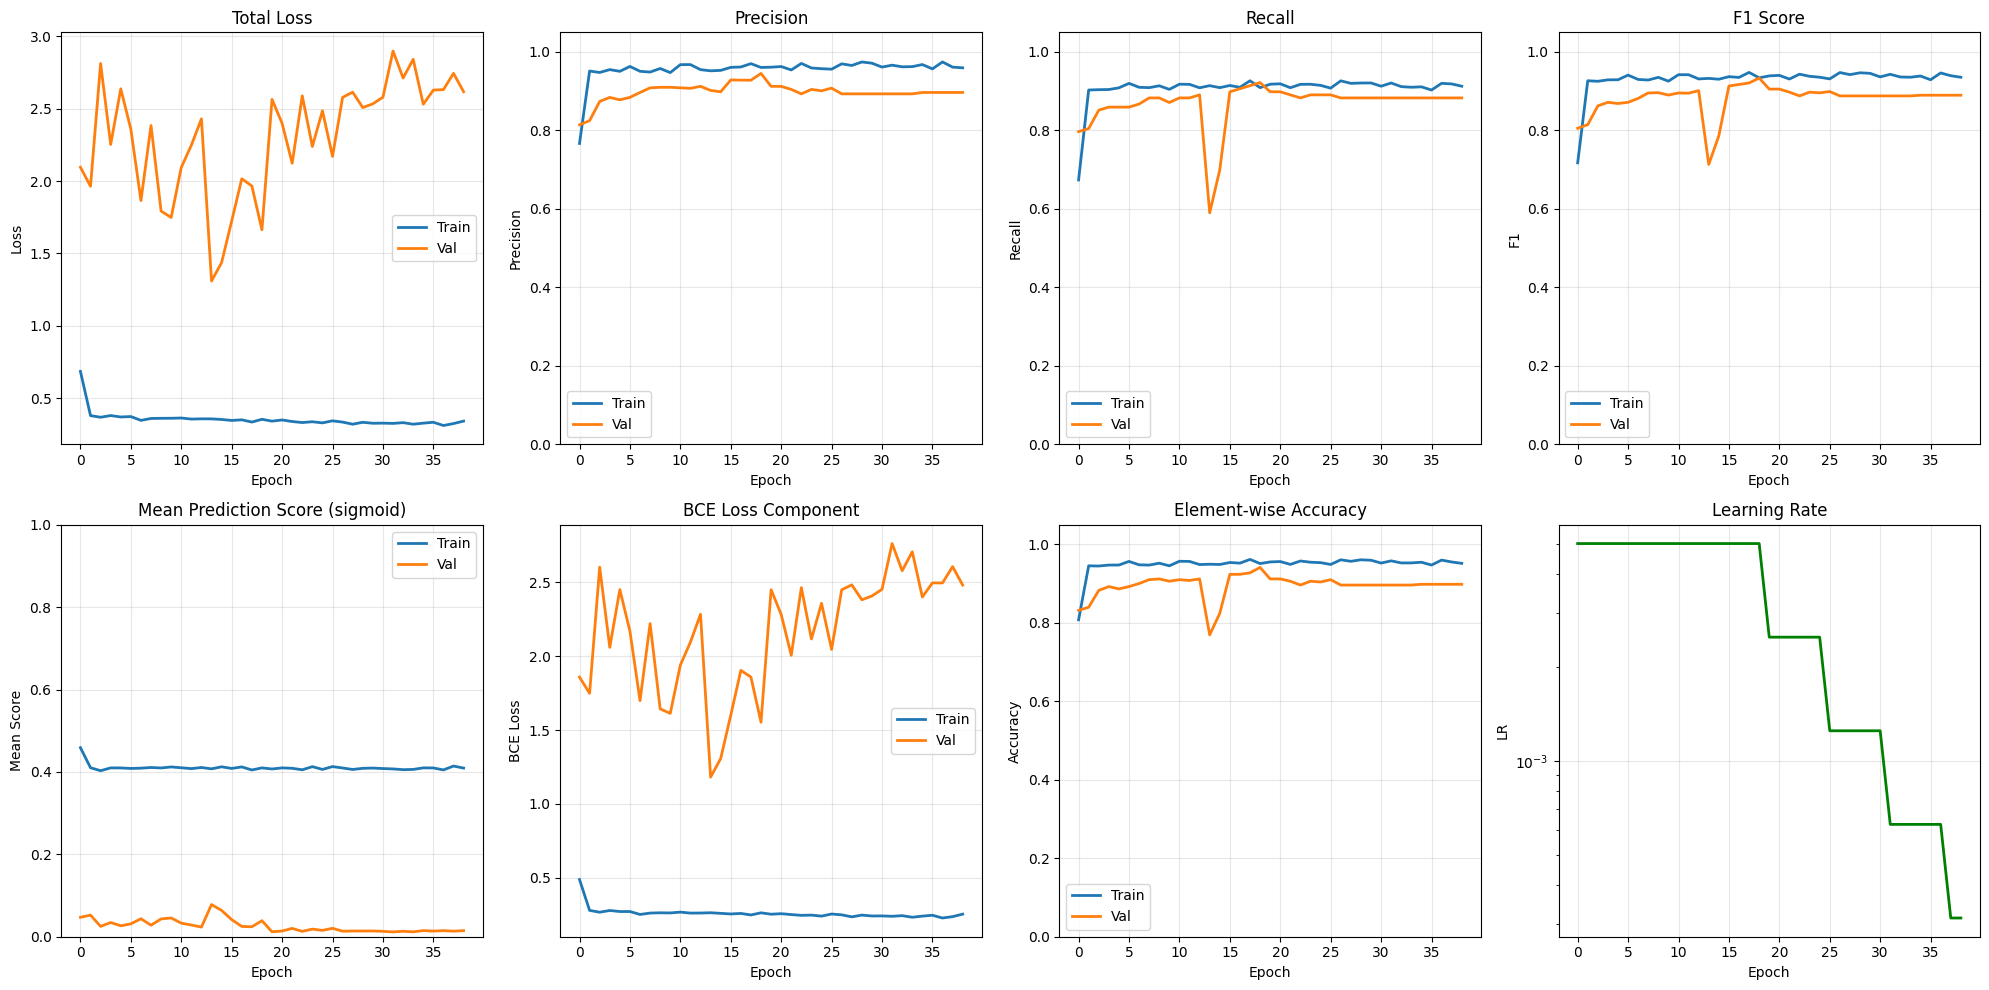

<Figure size 640x480 with 0 Axes>


✅ Training complete!
   Best validation loss: 1.6635
   Model saved to: Matching_Output/best_model.pt


In [15]:
# Check if data is loaded
if 'DATA_LOADED' not in dir() or not DATA_LOADED:
    print("⚠️ Data not loaded. Creating synthetic demo data...")
    
    # Create synthetic demo data for testing
    class DemoDataset(Dataset):
        def __init__(self, num_samples=100, num_joints=12):
            self.num_samples = num_samples
            self.num_joints = num_joints
        
        def __len__(self):
            return self.num_samples
        
        def __getitem__(self, idx):
            # Create random skeletons
            num_people = np.random.randint(1, 4)
            
            left_skeletons = []
            right_skeletons = []
            left_conf = []
            right_conf = []
            
            for _ in range(num_people):
                # Random skeleton in left view
                base_x = np.random.uniform(200, 1700)
                base_y = np.random.uniform(200, 900)
                left_skel = np.random.randn(self.num_joints, 2) * 50 + np.array([base_x, base_y])
                
                # Corresponding skeleton in right view (with disparity)
                disparity = np.random.uniform(50, 200)
                right_skel = left_skel.copy()
                right_skel[:, 0] -= disparity
                
                # Add some noise
                right_skel += np.random.randn(self.num_joints, 2) * 5
                
                # Random confidence
                conf = np.random.uniform(0.5, 1.0, self.num_joints)
                
                left_skeletons.append(left_skel)
                right_skeletons.append(right_skel)
                left_conf.append(conf)
                right_conf.append(conf)
            
            # Match matrix (diagonal - each left matches corresponding right)
            match_matrix = np.eye(num_people, dtype=np.float32)
            
            return {
                'left_skeletons': torch.tensor(np.stack(left_skeletons), dtype=torch.float32),
                'right_skeletons': torch.tensor(np.stack(right_skeletons), dtype=torch.float32),
                'left_confidences': torch.tensor(np.stack(left_conf), dtype=torch.float32),
                'right_confidences': torch.tensor(np.stack(right_conf), dtype=torch.float32),
                'match_matrix': torch.tensor(match_matrix, dtype=torch.float32),
                'gt_matching': [(i, i) for i in range(num_people)],
                'scene_name': f'demo_{idx}',
                'frame_idx': idx,
            }
    
    train_dataset = DemoDataset(200)
    val_dataset = DemoDataset(50)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_matching_batch
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_matching_batch
    )
    
    print("✅ Demo datasets created")

# Initialize model
print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)

model = SkeletonMatchingModel(config).to(DEVICE)
trainer = Trainer(model, config, train_loader, val_loader)

# Train
print("\n🚀 Starting training...")
history = trainer.train(num_epochs=config.num_epochs)

# Plot history
print("\n📊 Training complete. Plotting history...")
plot_training_history(history)
plt.savefig(os.path.join(config.output_dir, 'training_history.png'), dpi=150)
plt.show()

print(f"\n✅ Training complete!")
print(f"   Best validation loss: {trainer.best_val_loss:.4f}")
print(f"   Model saved to: {os.path.join(config.output_dir, 'best_model.pt')}")

In [16]:
"""
Hybrid Matcher: Geometric Baseline + Neural Network Refinement
===============================================================

Philosophy:
- Geometry handles 95% of cases correctly
- Neural network learns to fix the remaining 5%
- This is more data-efficient than learning everything from scratch

Architecture:
1. Compute geometric cost matrix (your baseline)
2. Neural network predicts:
   - Adjustment scores for each pair
   - Confidence that geometry might be wrong
3. Combine: final_score = geometric_score + learned_adjustment
4. Hungarian algorithm on combined scores
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.optimize import linear_sum_assignment
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional


# =============================================================================
# Data Structures
# =============================================================================

@dataclass
class SkeletonData:
    """Container for skeleton data."""
    keypoints: np.ndarray  # (num_joints, 2)
    confidences: np.ndarray  # (num_joints,)
    valid_mask: np.ndarray  # (num_joints,) boolean
    bbox: Optional[np.ndarray] = None  # [x1, y1, x2, y2]
    
    @property
    def num_valid_joints(self) -> int:
        return self.valid_mask.sum()
    
    @property
    def centroid(self) -> np.ndarray:
        if self.num_valid_joints > 0:
            return self.keypoints[self.valid_mask].mean(axis=0)
        return np.array([0, 0])


# =============================================================================
# Geometric Feature Extractor (Enhanced)
# =============================================================================

class GeometricFeatureExtractor:
    """Extract geometric features for matching."""
    
    def __init__(self, config: Config):
        self.config = config
        self.edges = config.skeleton_edges
    
    def compute_bone_lengths(self, skeleton: SkeletonData) -> np.ndarray:
        """Compute normalized bone lengths."""
        bone_lengths = []
        for i, j in self.edges:
            if skeleton.valid_mask[i] and skeleton.valid_mask[j]:
                length = np.linalg.norm(
                    skeleton.keypoints[i] - skeleton.keypoints[j]
                )
                bone_lengths.append(length)
            else:
                bone_lengths.append(0)
        return np.array(bone_lengths, dtype=np.float32)
    
    def compute_pairwise_features(self, left: SkeletonData, 
                                   right: SkeletonData) -> Dict[str, float]:
        """
        Compute geometric features for a left-right skeleton pair.
        Returns features that indicate match quality.
        """
        features = {}
        
        # Find commonly valid joints
        common_valid = left.valid_mask & right.valid_mask
        n_common = common_valid.sum()
        
        features['n_common_joints'] = n_common
        features['common_ratio'] = n_common / self.config.num_joints
        
        if n_common < 3:
            # Not enough common joints - return default high-cost features
            features['y_error'] = 1.0
            features['disparity_std'] = 1.0
            features['bone_ratio_error'] = 1.0
            features['centroid_y_diff'] = 1.0
            features['mean_disparity'] = 0.0
            features['disparity_valid'] = False
            return features
        
        # 1. Y-coordinate error (epipolar constraint)
        y_left = left.keypoints[common_valid, 1]
        y_right = right.keypoints[common_valid, 1]
        y_diff = np.abs(y_left - y_right)
        features['y_error'] = y_diff.mean() / self.config.image_height
        features['y_error_max'] = y_diff.max() / self.config.image_height
        features['y_error_std'] = y_diff.std() / self.config.image_height
        
        # 2. Disparity consistency
        x_left = left.keypoints[common_valid, 0]
        x_right = right.keypoints[common_valid, 0]
        disparities = x_left - x_right
        
        features['mean_disparity'] = disparities.mean()
        features['disparity_std'] = disparities.std() / (np.abs(disparities.mean()) + 1e-8)
        features['disparity_valid'] = (disparities > 0).all()  # Should all be positive for valid stereo
        
        # 3. Bone length consistency
        left_bones = self.compute_bone_lengths(left)
        right_bones = self.compute_bone_lengths(right)
        
        valid_bones = (left_bones > 0) & (right_bones > 0)
        if valid_bones.sum() > 0:
            ratio = np.maximum(left_bones[valid_bones], right_bones[valid_bones]) / \
                    (np.minimum(left_bones[valid_bones], right_bones[valid_bones]) + 1e-8)
            features['bone_ratio_error'] = (ratio - 1).mean()
            features['bone_ratio_max'] = (ratio - 1).max()
        else:
            features['bone_ratio_error'] = 1.0
            features['bone_ratio_max'] = 1.0
        
        # 4. Centroid features
        left_centroid = left.centroid
        right_centroid = right.centroid
        features['centroid_y_diff'] = abs(left_centroid[1] - right_centroid[1]) / self.config.image_height
        features['centroid_x_diff'] = (left_centroid[0] - right_centroid[0]) / self.config.image_width
        
        # 5. Size consistency (bounding box)
        if left.bbox is not None and right.bbox is not None:
            left_size = (left.bbox[2] - left.bbox[0]) * (left.bbox[3] - left.bbox[1])
            right_size = (right.bbox[2] - right.bbox[0]) * (right.bbox[3] - right.bbox[1])
            features['size_ratio'] = max(left_size, right_size) / (min(left_size, right_size) + 1e-8)
        else:
            features['size_ratio'] = 1.0
        
        return features
    
    def compute_geometric_cost(self, left: SkeletonData, right: SkeletonData) -> float:
        """Compute geometric matching cost (lower = better match)."""
        features = self.compute_pairwise_features(left, right)
        
        if features['n_common_joints'] < 3:
            return float('inf')
        
        # Weighted combination of geometric errors
        cost = (
            features['y_error'] * 100 +           # Y error is critical
            features['disparity_std'] * 50 +       # Disparity should be consistent
            features['bone_ratio_error'] * 30 +    # Bones should have same ratios
            features['centroid_y_diff'] * 20       # Centroids should align vertically
        )
        
        # Penalty for invalid disparity (right should be left of left camera view)
        if not features['disparity_valid']:
            cost += 100
        
        return cost


# =============================================================================
# Neural Network for Residual Learning
# =============================================================================

class PairwiseFeatureEncoder(nn.Module):
    """
    Encode a pair of skeletons into features for matching.
    
    Input: Geometric features + raw skeleton features
    Output: Embedding for the pair
    """
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        # Geometric feature dimension (from compute_pairwise_features)
        self.geo_feat_dim = 15
        
        # Skeleton encoder (per skeleton)
        self.skeleton_encoder = nn.Sequential(
            nn.Linear(config.num_joints * 3, 64),  # x, y, conf per joint
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        
        # Pair encoder
        self.pair_encoder = nn.Sequential(
            nn.Linear(32 * 2 + self.geo_feat_dim, 64),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        
    def encode_skeleton(self, keypoints: torch.Tensor, 
                       confidences: torch.Tensor) -> torch.Tensor:
        """
        Encode a single skeleton.
        
        Args:
            keypoints: (batch, num_joints, 2) normalized keypoints
            confidences: (batch, num_joints) confidence scores
        """
        # Concatenate x, y, confidence
        x = torch.cat([
            keypoints,
            confidences.unsqueeze(-1)
        ], dim=-1)  # (batch, num_joints, 3)
        
        x = x.view(x.shape[0], -1)  # Flatten
        return self.skeleton_encoder(x)
    
    def forward(self, left_kpts: torch.Tensor, left_conf: torch.Tensor,
               right_kpts: torch.Tensor, right_conf: torch.Tensor,
               geo_features: torch.Tensor) -> torch.Tensor:
        """
        Encode a skeleton pair.
        
        Returns:
            (batch,) pair embedding
        """
        left_emb = self.encode_skeleton(left_kpts, left_conf)
        right_emb = self.encode_skeleton(right_kpts, right_conf)
        
        pair_input = torch.cat([left_emb, right_emb, geo_features], dim=-1)
        return self.pair_encoder(pair_input)


class HybridMatchingHead(nn.Module):
    """
    Predict matching adjustments based on pair features.
    
    Outputs:
    1. Score adjustment (added to geometric score)
    2. Confidence that this match is correct
    3. Flag indicating geometry might be wrong
    """
    
    def __init__(self, config: Config):
        super().__init__()
        
        self.adjustment_head = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
        
        self.confidence_head = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )
        
        self.geometry_error_head = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, pair_features: torch.Tensor) -> Dict[str, torch.Tensor]:
        return {
            'adjustment': self.adjustment_head(pair_features).squeeze(-1),
            'confidence': self.confidence_head(pair_features).squeeze(-1),
            'geometry_error_prob': self.geometry_error_head(pair_features).squeeze(-1),
        }


class HybridMatcher(nn.Module):
    """
    Complete hybrid matching model.
    
    Combines geometric baseline with learned refinement.
    """
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        self.pair_encoder = PairwiseFeatureEncoder(config)
        self.matching_head = HybridMatchingHead(config)
        
        # Learnable weight for combining geometric and neural scores
        self.geo_weight = nn.Parameter(torch.tensor(0.8))
        self.neural_weight = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, left_kpts: torch.Tensor, left_conf: torch.Tensor,
               right_kpts: torch.Tensor, right_conf: torch.Tensor,
               geo_features: torch.Tensor, geo_costs: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Args:
            left_kpts: (batch, num_joints, 2) normalized keypoints
            left_conf: (batch, num_joints) confidences
            right_kpts: (batch, num_joints, 2)
            right_conf: (batch, num_joints)
            geo_features: (batch, geo_feat_dim) geometric features for this pair
            geo_costs: (batch,) geometric cost for this pair
            
        Returns:
            Dictionary with scores and diagnostics
        """
        # Encode pair
        pair_emb = self.pair_encoder(left_kpts, left_conf, right_kpts, right_conf, geo_features)
        
        # Get predictions
        preds = self.matching_head(pair_emb)
        
        # Convert geometric cost to score (lower cost = higher score)
        # Normalize cost to roughly [0, 1] range
        geo_score = torch.exp(-geo_costs / 50.0)  # Soft conversion
        
        # Combine geometric and neural scores
        # Neural adjustment is small correction
        combined_score = (
            torch.sigmoid(self.geo_weight) * geo_score +
            torch.sigmoid(self.neural_weight) * torch.tanh(preds['adjustment'])
        )
        
        return {
            'combined_score': combined_score,
            'geo_score': geo_score,
            'adjustment': preds['adjustment'],
            'confidence': preds['confidence'],
            'geometry_error_prob': preds['geometry_error_prob'],
        }


# =============================================================================
# Complete Hybrid Matching Pipeline
# =============================================================================

class HybridSkeletonMatcher:
    """
    Production-ready hybrid matcher.
    
    Uses geometric baseline + neural refinement.
    """
    
    def __init__(self, config: Config, model: HybridMatcher = None):
        self.config = config
        self.geo_extractor = GeometricFeatureExtractor(config)
        self.model = model
        
        if model is not None:
            self.model.eval()
    
    def _skeletons_to_tensors(self, skeletons: List[SkeletonData]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Convert skeleton list to tensors."""
        kpts = np.stack([s.keypoints for s in skeletons])
        confs = np.stack([s.confidences for s in skeletons])
        
        # Normalize keypoints
        kpts[:, :, 0] /= self.config.image_width
        kpts[:, :, 1] /= self.config.image_height
        
        return (
            torch.tensor(kpts, dtype=torch.float32),
            torch.tensor(confs, dtype=torch.float32)
        )
    
    def _features_to_tensor(self, features: Dict[str, float]) -> torch.Tensor:
        """Convert feature dict to tensor."""
        feat_keys = [
            'n_common_joints', 'common_ratio', 'y_error', 'y_error_max', 'y_error_std',
            'mean_disparity', 'disparity_std', 'disparity_valid',
            'bone_ratio_error', 'bone_ratio_max', 'centroid_y_diff', 'centroid_x_diff',
            'size_ratio'
        ]
        
        feat_list = []
        for key in feat_keys:
            val = features.get(key, 0.0)
            if isinstance(val, bool):
                val = float(val)
            feat_list.append(val)
        
        # Pad to expected size
        while len(feat_list) < 15:
            feat_list.append(0.0)
        
        return torch.tensor(feat_list[:15], dtype=torch.float32)
    
    def match(self, left_skeletons: List[SkeletonData],
              right_skeletons: List[SkeletonData],
              use_neural: bool = True) -> Dict:
        """
        Match skeletons between views.
        
        Args:
            left_skeletons: List of left camera skeletons
            right_skeletons: List of right camera skeletons
            use_neural: Whether to use neural refinement (if model available)
            
        Returns:
            Dictionary with matches and diagnostics
        """
        n_left = len(left_skeletons)
        n_right = len(right_skeletons)
        
        if n_left == 0 or n_right == 0:
            return {
                'matches': [],
                'cost_matrix': np.array([]),
                'score_matrix': np.array([]),
            }
        
        # Step 1: Compute geometric costs
        geo_cost_matrix = np.full((n_left, n_right), 1000.0, dtype=np.float32)
        geo_features_matrix = []
        
        for i in range(n_left):
            geo_features_row = []
            for j in range(n_right):
                cost = self.geo_extractor.compute_geometric_cost(
                    left_skeletons[i], right_skeletons[j]
                )
                geo_cost_matrix[i, j] = min(cost, 1000.0)
                
                features = self.geo_extractor.compute_pairwise_features(
                    left_skeletons[i], right_skeletons[j]
                )
                geo_features_row.append(features)
            geo_features_matrix.append(geo_features_row)
        
        # Step 2: Neural refinement (if model available and enabled)
        if self.model is not None and use_neural:
            score_matrix = self._apply_neural_refinement(
                left_skeletons, right_skeletons,
                geo_cost_matrix, geo_features_matrix
            )
        else:
            # Convert cost to score (lower cost = higher score)
            score_matrix = np.exp(-geo_cost_matrix / 50.0)
        
        # Step 3: Hungarian algorithm on score matrix (maximize score)
        cost_for_hungarian = -score_matrix  # Negate to maximize
        row_ind, col_ind = linear_sum_assignment(cost_for_hungarian)
        
        # Step 4: Filter matches by score threshold
        matches = []
        match_scores = []
        
        for i, j in zip(row_ind, col_ind):
            score = score_matrix[i, j]
            geo_cost = geo_cost_matrix[i, j]
            
            # Accept match if:
            # - Score is above threshold, OR
            # - Geometric cost is very low (strong geometric match)
            if score > 0.3 or geo_cost < 50:
                matches.append((int(i), int(j)))
                match_scores.append(float(score))
        
        return {
            'matches': matches,
            'match_scores': match_scores,
            'cost_matrix': geo_cost_matrix,
            'score_matrix': score_matrix,
        }
    
    @torch.no_grad()
    def _apply_neural_refinement(self, left_skeletons: List[SkeletonData],
                                  right_skeletons: List[SkeletonData],
                                  geo_cost_matrix: np.ndarray,
                                  geo_features_matrix: List[List[Dict]]) -> np.ndarray:
        """Apply neural network to refine geometric scores."""
        n_left = len(left_skeletons)
        n_right = len(right_skeletons)
        
        score_matrix = np.zeros((n_left, n_right), dtype=np.float32)
        
        # Convert skeletons to tensors
        left_kpts, left_conf = self._skeletons_to_tensors(left_skeletons)
        right_kpts, right_conf = self._skeletons_to_tensors(right_skeletons)
        
        # Process each pair
        for i in range(n_left):
            for j in range(n_right):
                geo_feat = self._features_to_tensor(geo_features_matrix[i][j])
                geo_cost = torch.tensor([geo_cost_matrix[i, j]], dtype=torch.float32)
                
                outputs = self.model(
                    left_kpts[i:i+1], left_conf[i:i+1],
                    right_kpts[j:j+1], right_conf[j:j+1],
                    geo_feat.unsqueeze(0), geo_cost
                )
                
                score_matrix[i, j] = outputs['combined_score'].item()
        
        return score_matrix


# =============================================================================
# Training for Hybrid Model
# =============================================================================

class HybridMatchingLoss(nn.Module):
    """Loss for training hybrid matcher."""
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
    
    def forward(self, outputs: Dict[str, torch.Tensor],
               targets: torch.Tensor,
               geo_costs: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Args:
            outputs: Model outputs for all pairs in batch
            targets: (batch,) binary labels (1 = match, 0 = no match)
            geo_costs: (batch,) geometric costs
        """
        # Main matching loss: BCE on combined score
        bce = F.binary_cross_entropy(
            outputs['combined_score'].clamp(1e-7, 1-1e-7),
            targets
        )
        
        # Confidence calibration: confidence should correlate with correctness
        confidence_target = (outputs['combined_score'].detach() > 0.5).float()
        confidence_target = confidence_target * targets + (1 - confidence_target) * (1 - targets)
        confidence_loss = F.binary_cross_entropy(
            outputs['confidence'],
            confidence_target
        )
        
        # Geometry error detection: should be high when geo says match but it's wrong
        geo_says_match = (geo_costs < 50).float()
        geo_wrong = geo_says_match * (1 - targets)  # Geo says match but wrong
        geo_error_loss = F.binary_cross_entropy(
            outputs['geometry_error_prob'],
            geo_wrong
        )
        
        total = bce + 0.3 * confidence_loss + 0.2 * geo_error_loss
        
        return {
            'total': total,
            'bce': bce,
            'confidence': confidence_loss,
            'geo_error': geo_error_loss,
        }


# =============================================================================
# Dataset for Hybrid Training
# =============================================================================

class HybridMatchingDataset(Dataset):
    """
    Dataset that provides pairwise samples for hybrid training.
    
    Each sample is a (left_skeleton, right_skeleton) pair with:
    - Geometric features
    - Label (match or not)
    """
    
    def __init__(self, config: Config, scenes_data: List[Dict], mode: str = 'train'):
        self.config = config
        self.mode = mode
        self.geo_extractor = GeometricFeatureExtractor(config)
        
        self.samples = []
        self._build_samples(scenes_data)
        
        print(f"📊 Created {mode} dataset with {len(self.samples)} pair samples")
    
    def _build_samples(self, scenes_data: List[Dict]):
        """Build pairwise samples from scenes."""
        
        for scene_data in scenes_data:
            characters = scene_data['characters']
            num_frames = scene_data['num_frames']
            
            char_names = list(characters.keys())
            n_chars = len(char_names)
            
            if n_chars == 0:
                continue
            
            for frame_idx in range(num_frames):
                # Get all skeletons for this frame
                left_skeletons = []
                right_skeletons = []
                
                for char_name in char_names:
                    char_data = characters[char_name]
                    if frame_idx < len(char_data.get('camleft', [])):
                        left_kpts = char_data['camleft'][frame_idx, :, :2]
                        right_kpts = char_data['camright'][frame_idx, :, :2]
                        
                        left_skeletons.append({
                            'keypoints': left_kpts,
                            'confidences': np.ones(self.config.num_joints),
                            'char_name': char_name,
                        })
                        right_skeletons.append({
                            'keypoints': right_kpts,
                            'confidences': np.ones(self.config.num_joints),
                            'char_name': char_name,
                        })
                
                # Create all pairs (positive = same character, negative = different)
                for i, left in enumerate(left_skeletons):
                    for j, right in enumerate(right_skeletons):
                        is_match = (left['char_name'] == right['char_name'])
                        
                        self.samples.append({
                            'left_keypoints': left['keypoints'],
                            'left_confidences': left['confidences'],
                            'right_keypoints': right['keypoints'],
                            'right_confidences': right['confidences'],
                            'is_match': is_match,
                            'scene': scene_data['scene_name'],
                            'frame': frame_idx,
                        })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx) -> Dict:
        sample = self.samples[idx]
        
        left_kpts = sample['left_keypoints'].copy()
        right_kpts = sample['right_keypoints'].copy()
        left_conf = sample['left_confidences'].copy()
        right_conf = sample['right_confidences'].copy()
        
        # Data augmentation for training
        if self.mode == 'train':
            # Add noise
            noise_std = self.config.aug_noise_std * self.config.image_width
            left_kpts += np.random.randn(*left_kpts.shape) * noise_std
            right_kpts += np.random.randn(*right_kpts.shape) * noise_std
            
            # Random joint dropout
            for k in range(len(left_kpts)):
                if np.random.random() < self.config.aug_dropout_prob:
                    left_conf[k] = 0
                if np.random.random() < self.config.aug_dropout_prob:
                    right_conf[k] = 0
        
        # Create SkeletonData for feature extraction
        left_skel = SkeletonData(
            keypoints=left_kpts,
            confidences=left_conf,
            valid_mask=left_conf > 0.3
        )
        right_skel = SkeletonData(
            keypoints=right_kpts,
            confidences=right_conf,
            valid_mask=right_conf > 0.3
        )
        
        # Compute geometric features and cost
        geo_features = self.geo_extractor.compute_pairwise_features(left_skel, right_skel)
        geo_cost = self.geo_extractor.compute_geometric_cost(left_skel, right_skel)
        
        # Convert features to tensor
        feat_keys = [
            'n_common_joints', 'common_ratio', 'y_error', 'y_error_max', 'y_error_std',
            'mean_disparity', 'disparity_std', 'disparity_valid',
            'bone_ratio_error', 'bone_ratio_max', 'centroid_y_diff', 'centroid_x_diff',
            'size_ratio'
        ]
        feat_list = []
        for key in feat_keys:
            val = geo_features.get(key, 0.0)
            if isinstance(val, bool):
                val = float(val)
            feat_list.append(val)
        while len(feat_list) < 15:
            feat_list.append(0.0)
        
        # Normalize keypoints
        left_kpts_norm = left_kpts.copy()
        right_kpts_norm = right_kpts.copy()
        left_kpts_norm[:, 0] /= self.config.image_width
        left_kpts_norm[:, 1] /= self.config.image_height
        right_kpts_norm[:, 0] /= self.config.image_width
        right_kpts_norm[:, 1] /= self.config.image_height
        
        return {
            'left_keypoints': torch.tensor(left_kpts_norm, dtype=torch.float32),
            'left_confidences': torch.tensor(left_conf, dtype=torch.float32),
            'right_keypoints': torch.tensor(right_kpts_norm, dtype=torch.float32),
            'right_confidences': torch.tensor(right_conf, dtype=torch.float32),
            'geo_features': torch.tensor(feat_list[:15], dtype=torch.float32),
            'geo_cost': torch.tensor(min(geo_cost, 1000.0), dtype=torch.float32),
            'is_match': torch.tensor(float(sample['is_match']), dtype=torch.float32),
        }


# =============================================================================
# Trainer for Hybrid Model
# =============================================================================

class HybridTrainer:
    """Trainer for hybrid matching model."""
    
    def __init__(self, model: HybridMatcher, config: Config,
                 train_loader: DataLoader, val_loader: DataLoader = None):
        self.model = model.to(DEVICE)
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.optimizer = AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        
        self.criterion = HybridMatchingLoss(config)
        self.best_val_auc = 0.0
        self.history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
    
    def compute_auc(self, scores: np.ndarray, labels: np.ndarray) -> float:
        """Compute AUC for pair classification."""
        from sklearn.metrics import roc_auc_score
        try:
            return roc_auc_score(labels, scores)
        except:
            return 0.5
    
    def train_epoch(self) -> float:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        n_batches = 0
        
        for batch in tqdm(self.train_loader, desc="Training"):
            self.optimizer.zero_grad()
            
            outputs = self.model(
                batch['left_keypoints'].to(DEVICE),
                batch['left_confidences'].to(DEVICE),
                batch['right_keypoints'].to(DEVICE),
                batch['right_confidences'].to(DEVICE),
                batch['geo_features'].to(DEVICE),
                batch['geo_cost'].to(DEVICE),
            )
            
            losses = self.criterion(
                outputs,
                batch['is_match'].to(DEVICE),
                batch['geo_cost'].to(DEVICE)
            )
            
            losses['total'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            total_loss += losses['total'].item()
            n_batches += 1
        
        return total_loss / n_batches
    
    @torch.no_grad()
    def validate(self) -> Tuple[float, float]:
        """Validate and return loss and AUC."""
        self.model.eval()
        
        all_scores = []
        all_labels = []
        total_loss = 0
        n_batches = 0
        
        for batch in self.val_loader:
            outputs = self.model(
                batch['left_keypoints'].to(DEVICE),
                batch['left_confidences'].to(DEVICE),
                batch['right_keypoints'].to(DEVICE),
                batch['right_confidences'].to(DEVICE),
                batch['geo_features'].to(DEVICE),
                batch['geo_cost'].to(DEVICE),
            )
            
            losses = self.criterion(
                outputs,
                batch['is_match'].to(DEVICE),
                batch['geo_cost'].to(DEVICE)
            )
            
            total_loss += losses['total'].item()
            n_batches += 1
            
            all_scores.extend(outputs['combined_score'].cpu().numpy().tolist())
            all_labels.extend(batch['is_match'].numpy().tolist())
        
        auc = self.compute_auc(np.array(all_scores), np.array(all_labels))
        
        return total_loss / n_batches, auc
    
    def train(self, num_epochs: int) -> Dict:
        """Full training loop."""
        print(f"🚀 Training hybrid model for {num_epochs} epochs")
        
        for epoch in range(num_epochs):
            train_loss = self.train_epoch()
            val_loss, val_auc = self.validate()
            
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_auc'].append(val_auc)
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, AUC: {val_auc:.4f}")
            
            if val_auc > self.best_val_auc:
                self.best_val_auc = val_auc
                torch.save(self.model.state_dict(), 
                          os.path.join(self.config.output_dir, 'hybrid_best.pt'))
                print("  ✓ New best model")
        
        return self.history


print("✅ Hybrid matching architecture defined")

✅ Hybrid matching architecture defined


In [18]:
class BaselineMatcher:
    """Baseline geometric-only matcher."""
    
    def __init__(self, config: Config):
        self.config = config
        self.geo_extractor = GeometricFeatureExtractor(config)
        
    def match(self, left_skeletons: List[SkeletonData],
              right_skeletons: List[SkeletonData]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """Match using only geometric heuristics."""
        if len(left_skeletons) == 0 or len(right_skeletons) == 0:
            return [], np.array([])
        
        n_left = len(left_skeletons)
        n_right = len(right_skeletons)
        
        cost_matrix = np.full((n_left, n_right), self.config.max_disparity, dtype=np.float32)
        
        for i, left in enumerate(left_skeletons):
            for j, right in enumerate(right_skeletons):
                cost = 0.0
                count = 0
                
                # Y-coordinate constraint (epipolar)
                y_diffs = []
                for k in range(len(left.keypoints)):
                    if left.valid_mask[k] and right.valid_mask[k]:
                        y_diffs.append(abs(left.keypoints[k][1] - right.keypoints[k][1]))
                        
                if y_diffs:
                    cost += np.mean(y_diffs)
                    count += 1
                
                # Disparity consistency
                disparities = []
                for k in range(len(left.keypoints)):
                    if left.valid_mask[k] and right.valid_mask[k]:
                        disparities.append(left.keypoints[k][0] - right.keypoints[k][0])
                        
                if len(disparities) > 1:
                    cost += np.std(disparities) * 2
                    count += 1
                
                # Bone length similarity
                left_bones = self.geo_extractor.compute_bone_lengths(left)
                right_bones = self.geo_extractor.compute_bone_lengths(right)
                
                if left_bones.sum() > 0 and right_bones.sum() > 0:
                    left_norm = left_bones / (left_bones.sum() + 1e-8)
                    right_norm = right_bones / (right_bones.sum() + 1e-8)
                    cost += np.abs(left_norm - right_norm).sum() * 20
                    count += 1
                
                if count > 0:
                    cost_matrix[i, j] = cost / count
        
        # Solve using Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        matches = []
        for i, j in zip(row_ind, col_ind):
            if cost_matrix[i, j] < self.config.max_disparity * 0.5:
                matches.append((int(i), int(j)))
                
        return matches, cost_matrix


print("Baseline matcher defined.")

Baseline matcher defined.


In [22]:
"""
Compare baseline geometric matcher with hybrid matcher.
"""

def evaluate_matcher(matcher, scene_data: Dict, use_neural: bool = True) -> Dict:
    """Evaluate a matcher on a scene."""
    characters = scene_data['characters']
    num_frames = scene_data['num_frames']
    
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for frame_idx in range(num_frames):
        # Build skeleton lists
        left_skeletons = []
        right_skeletons = []
        char_names = []
        
        for char_name, char_data in characters.items():
            if frame_idx < len(char_data.get('camleft', [])):
                left_kpts = char_data['camleft'][frame_idx, :, :2]
                right_kpts = char_data['camright'][frame_idx, :, :2]
                
                left_skel = SkeletonData(
                    keypoints=left_kpts,
                    confidences=np.ones(config.num_joints),
                    valid_mask=np.ones(config.num_joints, dtype=bool)
                )
                right_skel = SkeletonData(
                    keypoints=right_kpts,
                    confidences=np.ones(config.num_joints),
                    valid_mask=np.ones(config.num_joints, dtype=bool)
                )
                
                left_skeletons.append(left_skel)
                right_skeletons.append(right_skel)
                char_names.append(char_name)
        
        if len(left_skeletons) == 0:
            continue
        
        # Ground truth: diagonal matching
        gt_matches = set((i, i) for i in range(len(left_skeletons)))
        
        # Run matcher
        if hasattr(matcher, 'match'):
            if isinstance(matcher, HybridSkeletonMatcher):
                result = matcher.match(left_skeletons, right_skeletons, use_neural=use_neural)
                pred_matches = set(result['matches'])
            else:
                matches, _ = matcher.match(left_skeletons, right_skeletons)
                pred_matches = set(matches)
        
        # Compute metrics
        tp = len(pred_matches & gt_matches)
        fp = len(pred_matches - gt_matches)
        fn = len(gt_matches - pred_matches)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
    
    precision = total_tp / (total_tp + total_fp + 1e-8)
    recall = total_tp / (total_tp + total_fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
    }


# Example usage:
print("=" * 60)
print("COMPARING MATCHERS")
print("=" * 60)

# 1. Baseline geometric matcher
baseline = BaselineMatcher(config)

# 2. Hybrid matcher (geometric only - no neural yet)
hybrid_geo_only = HybridSkeletonMatcher(config, model=None)

# 3. Train and evaluate hybrid with neural network
# ... (training code here)

# Evaluate on test scenes
if 'test_scenes' in dir():
    for scene in test_scenes:
        print(f"\n📊 {scene['scene_name']}")
        
        baseline_metrics = evaluate_matcher(baseline, scene)
        print(f"  Baseline:  P={baseline_metrics['precision']:.4f}, "
              f"R={baseline_metrics['recall']:.4f}, F1={baseline_metrics['f1']:.4f}")
        
        hybrid_geo_metrics = evaluate_matcher(hybrid_geo_only, scene, use_neural=False)
        print(f"  Hybrid(G): P={hybrid_geo_metrics['precision']:.4f}, "
              f"R={hybrid_geo_metrics['recall']:.4f}, F1={hybrid_geo_metrics['f1']:.4f}")

COMPARING MATCHERS

📊 Scene 3 - Busy Streets (93 frames)
  Baseline:  P=1.0000, R=1.0000, F1=1.0000
  Hybrid(G): P=1.0000, R=1.0000, F1=1.0000

📊 Scene 4b - Night (140 frames)
  Baseline:  P=1.0000, R=1.0000, F1=1.0000
  Hybrid(G): P=1.0000, R=1.0000, F1=1.0000
